In [1]:
#env:ml-s7
import numpy as np
import pandas as pd
# from icecream import ic
import subprocess
import json
import os
import plotly.graph_objects as go
from matplotlib import pyplot as plt
# import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely.ops import cascaded_union, unary_union
# from shapely import geometry
# from geopy import distance
%matplotlib inline
import plotly.express as px 
from scipy import signal
from tqdm import tqdm
# from Bio import Phylo
# import ete3
import itertools
import sklearn

In [2]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

## Data prep

In [3]:


def data_prep(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']

    variants = pd.read_csv('variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(variants['sample_id'].unique()):
        aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'

    return aa_array, mic_aa

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

# Assuming aa_array is a numpy array and mic_aa['EMB_MIC'] is a pandas Series
def data_split(aa_array, encoded_mic):
    # Encode the target variable
    
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

# The train_data and test_data now have the same proportion of target values as the original data
# print("Train data shape:", train_data.shape)
# print("Test data shape:", test_data.shape)
# print("Train target distribution:", np.bincount(train_target))
# print("Test target distribution:", np.bincount(test_target))


# trainning binary classifier

In [5]:
# Initialize and train the RandomForestClassifier
def training_classifier(train_data, train_target, test_data, test_target, drug_name:str):
    clf = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=1000, class_weight="balanced")
    clf.fit(train_data, train_target)

    # Predict on the test data
    test_predictions = clf.predict(test_data)

    # Calculate accuracy
    accuracy = accuracy_score(test_target, test_predictions)
    print('Drugs:', drug_name)
    print("Accuracy:", accuracy)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(test_target, test_predictions)

    # Calculate sensitivity, specificity, and F1 score
    tp = conf_matrix[1, 1]  # True Positive
    tn = conf_matrix[0, 0]  # True Negative
    fp = conf_matrix[0, 1]  # False Positive
    fn = conf_matrix[1, 0]  # False Negative

    sensitivity = tp / (tp + fn)  # Sensitivity (Recall)
    specificity = tn / (tn + fp)  # Specificity
    f1 = f1_score(test_target, test_predictions)  # F1 Score
    auc = roc_auc_score(test_target, clf.predict_proba(test_data)[:, 1])  # AUC

    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    print("F1 Score:", f1)
    print("AUC:", auc)


    # Plot confusion matrix using Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['sus', 'res'])
    plt.yticks(tick_marks, ['sus', 'res'])

    # Labeling the plot
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Loop over data dimensions and create text annotations.
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.show()

# Binary resistance

## EMB

/tmp/ipykernel_59578/4213895946.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_59578/4213895946.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.125'
/tmp/ipykernel_59578/4213895946.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float')
100%|████████

Drugs: all
Accuracy: 0.9213973799126638
Sensitivity (Recall): 0.8433734939759037
Specificity: 0.9532595325953259
F1 Score: 0.8615384615384616
AUC: 0.9128988277834587


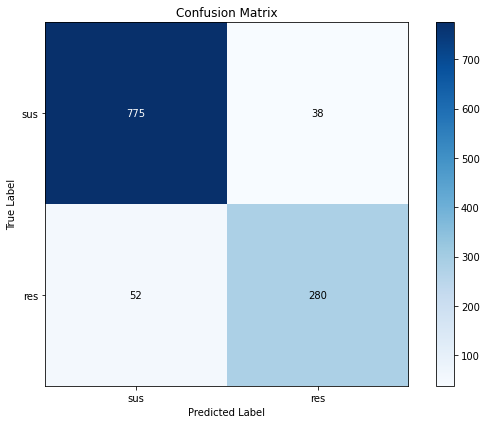

100%|██████████| 8334/8334 [00:31<00:00, 268.73it/s]
/tmp/ipykernel_59578/2072411084.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_59578/2072411084.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())


Drugs: remove low quality
Accuracy: 0.9187772925764193
Sensitivity (Recall): 0.8373493975903614
Specificity: 0.9520295202952029
F1 Score: 0.8567026194144838
AUC: 0.9146827161042694


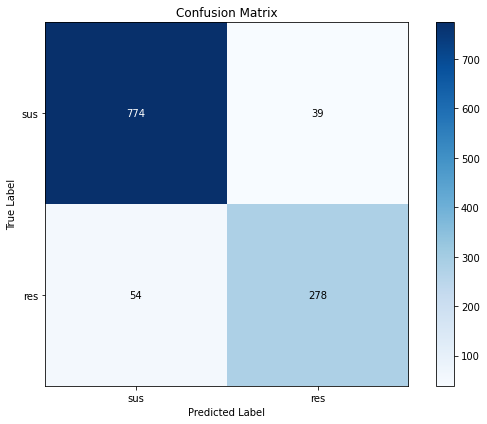

100%|██████████| 7223/7223 [00:23<00:00, 301.90it/s]
/tmp/ipykernel_59578/2072411084.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_59578/2072411084.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())


Drugs: remove low and medium quality
Accuracy: 0.9196506550218341
Sensitivity (Recall): 0.8403614457831325
Specificity: 0.9520295202952029
F1 Score: 0.8584615384615385
AUC: 0.9152514115502601


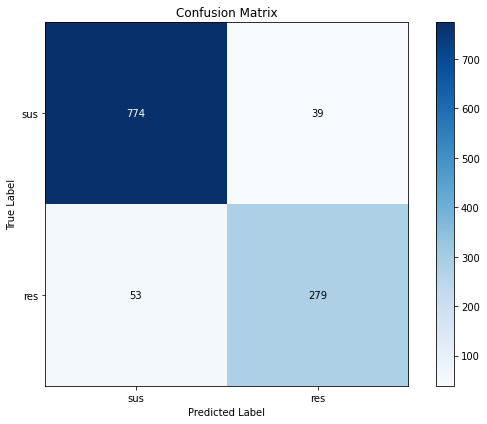

In [8]:
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 


variants = pd.read_csv('variants_full.csv')
variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
train_data, val_data, train_target, val_target  = data_split(train_data, train_target)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

train_data, val_data, train_target, val_target  = data_split(train_data, train_target)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

train_data, val_data, train_target, val_target  = data_split(train_data, train_target)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## ETH

In [623]:
drug = 'ETH'
gene_list = ['ethA', 'inhA', 'katG']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]

In [626]:
df_emb['ETH_MIC'].value_counts()

1.0       4455
2.0       2875
0.5       1835
>8         974
4.0        972
8.0        753
<=0.25     266
Name: ETH_MIC, dtype: int64

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/390614533.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Drugs: all
Accuracy: 0.8298611111111112
Sensitivity (Recall): 0.536036036036036
Specificity: 0.9314641744548287
F1 Score: 0.6181818181818182
AUC: 0.8138559119867531


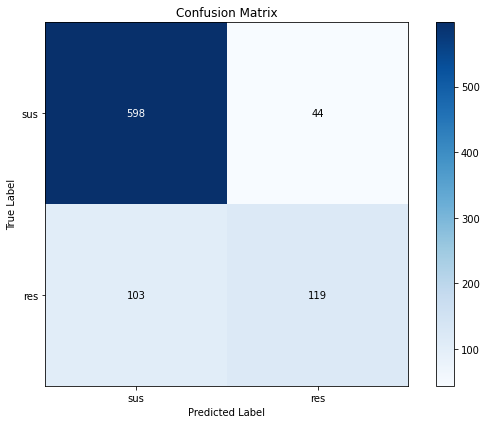

100%|██████████| 7254/7254 [00:20<00:00, 349.14it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.8278236914600551
Sensitivity (Recall): 0.5268817204301075
Specificity: 0.9314814814814815
F1 Score: 0.6105919003115265
AUC: 0.7959776981282358


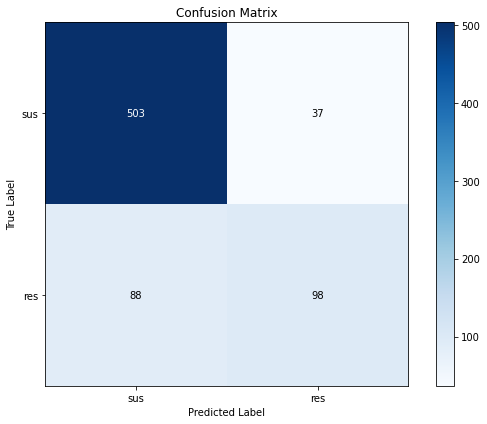

100%|██████████| 6287/6287 [00:15<00:00, 393.94it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.8457869634340223
Sensitivity (Recall): 0.5533333333333333
Specificity: 0.9373695198329853
F1 Score: 0.6311787072243347
AUC: 0.8109951287404314


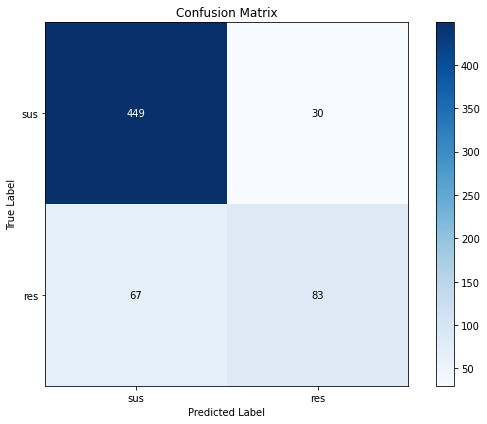

In [40]:
drug = 'ETH'
gene_list = ['ethA', 'inhA', 'katG']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

variants = pd.read_csv('variants_full.csv')
variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## INH

In [628]:
res_thresh = 0.1
drug = 'INH'
gene_list = ['inhA', 'katG','kasA']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>1.6','0.8', '0.4', '0.2', '0.1', '0.05', '<=0.025'])]
df_emb[f'{drug}_MIC'].value_counts()

0.05       3428
<=0.025    2458
>1.6       1647
0.2         366
0.8         349
0.4         307
0.1         275
Name: INH_MIC, dtype: int64

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/486340888.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Drugs: all
Accuracy: 0.8771121351766513
Sensitivity (Recall): 0.7186311787072244
Specificity: 0.9845360824742269
F1 Score: 0.8253275109170305
AUC: 0.8998520246168319


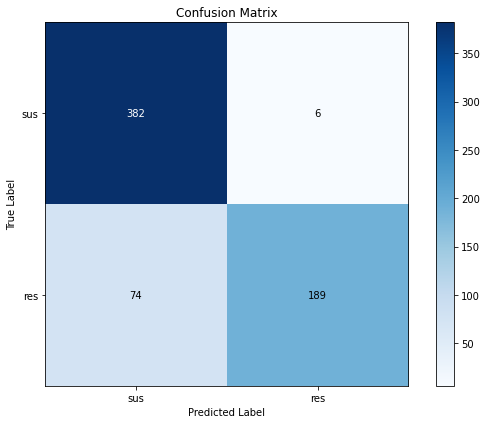

100%|██████████| 5892/5892 [00:12<00:00, 486.93it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.8728813559322034
Sensitivity (Recall): 0.6991525423728814
Specificity: 0.9887005649717514
F1 Score: 0.8148148148148149
AUC: 0.8937027195250408


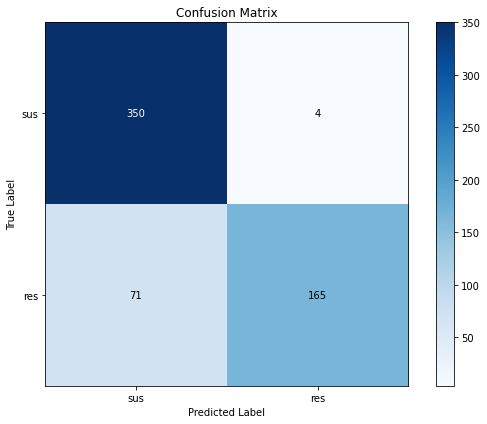

100%|██████████| 5294/5294 [00:10<00:00, 515.25it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.8943396226415095
Sensitivity (Recall): 0.7352941176470589
Specificity: 0.9938650306748467
F1 Score: 0.8426966292134831
AUC: 0.922102429929027


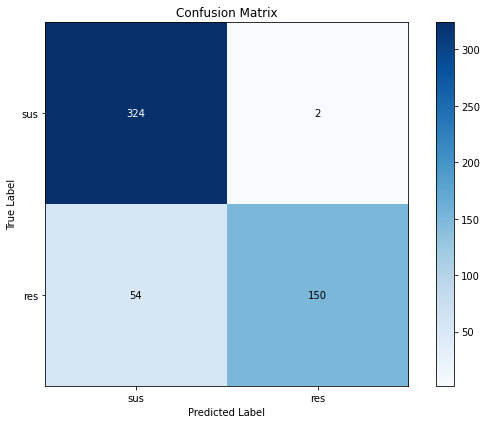

In [41]:
res_thresh = 0.1
drug = 'INH'
gene_list = ['inhA', 'katG','kasA']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>1.6','0.8', '0.4', '0.2', '0.1', '0.05', '<=0.025'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>1.6' :
        df_emb.loc[i, f'{x}'] = '3.2'
    elif row[x] == '<=0.025':
        df_emb.loc[i, f'{x}'] = '0.0125'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

variants = pd.read_csv('variants_full.csv')
variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## RIF

In [629]:
drug = 'RIF'
res_thresh = 0.5
gene_list = ['rpoA', 'rpoB', 'rpoC']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>4','4', '2', '1', '0.5', '0.25', '0.12', '<=0.06'])]
df_emb[f'{drug}_MIC'].value_counts()

<=0.06    2318
>4        2243
0.12      2106
0.25       723
0.5        188
Name: RIF_MIC, dtype: int64

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/656342223.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Drugs: all
Accuracy: 0.9453376205787781
Sensitivity (Recall): 0.9184549356223176
Specificity: 0.961439588688946
F1 Score: 0.9264069264069263
AUC: 0.9586703002085242


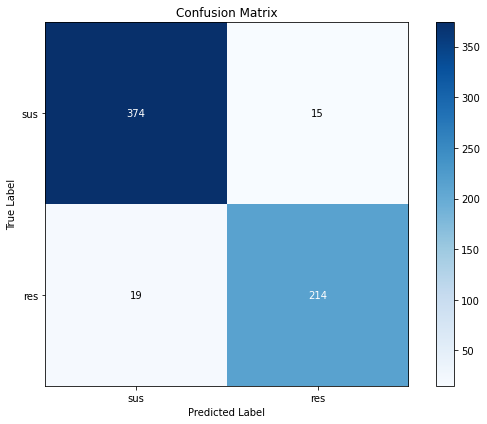

100%|██████████| 5419/5419 [00:14<00:00, 369.88it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.959409594095941
Sensitivity (Recall): 0.9508928571428571
Specificity: 0.9654088050314465
F1 Score: 0.9508928571428571
AUC: 0.9758886455525607


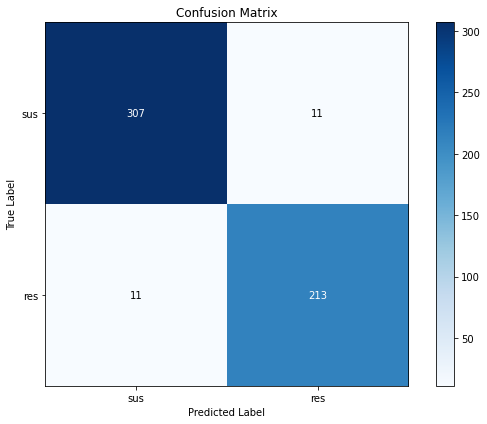

100%|██████████| 4682/4682 [00:11<00:00, 414.18it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.9488272921108742
Sensitivity (Recall): 0.9095744680851063
Specificity: 0.9750889679715302
F1 Score: 0.9344262295081968
AUC: 0.9638449307185584


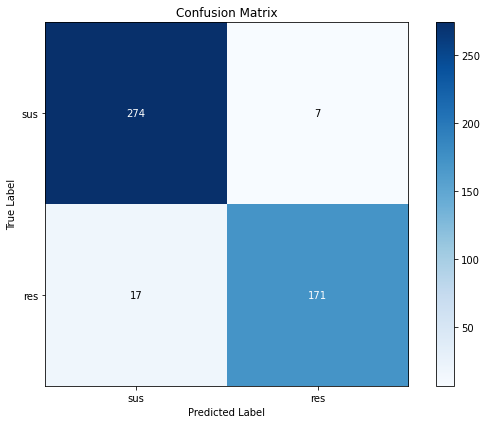

In [42]:
drug = 'RIF'
res_thresh = 0.5
gene_list = ['rpoA', 'rpoB', 'rpoC']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>4','4', '2', '1', '0.5', '0.25', '0.12', '<=0.06'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>4' :
        df_emb.loc[i, f'{x}'] = '8'
    elif row[x] == '<=0.06':
        df_emb.loc[i, f'{x}'] = '0.03'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 


cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## RFB

In [630]:
drug = 'RFB'
res_thresh = 0.12
gene_list = ['rpoA', 'rpoB', 'rpoC']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>2','2', '1', '0.5', '0.25', '0.12', '<=0.06'])]
df_emb[f'{drug}_MIC'].value_counts()

<=0.06    7210
>2        3097
0.12       474
0.25       287
0.5        210
Name: RFB_MIC, dtype: int64

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/486447723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Drugs: all
Accuracy: 0.9383783783783783
Sensitivity (Recall): 0.9102902374670184
Specificity: 0.9578754578754579
F1 Score: 0.9236947791164659
AUC: 0.9619661341297225


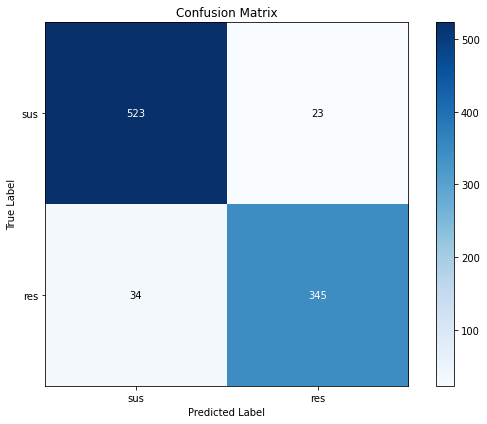

100%|██████████| 8832/8832 [00:34<00:00, 256.59it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.9445701357466063
Sensitivity (Recall): 0.8997134670487106
Specificity: 0.9738317757009346
F1 Score: 0.9276218611521417
AUC: 0.9621294486249097


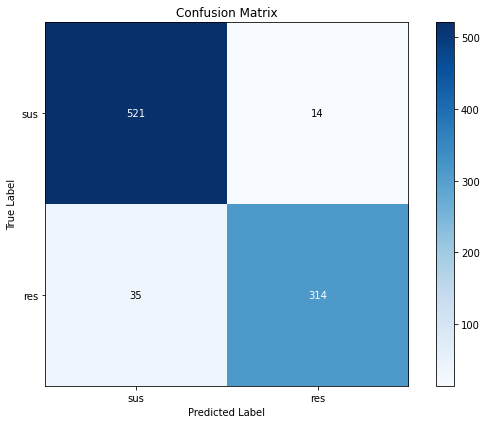

100%|██████████| 7897/7897 [00:27<00:00, 282.74it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.9455696202531646
Sensitivity (Recall): 0.911864406779661
Specificity: 0.9656565656565657
F1 Score: 0.9259896729776247
AUC: 0.9676014381099128


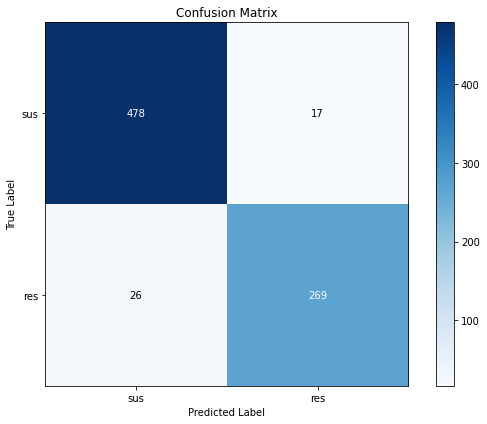

In [43]:
drug = 'RFB'
res_thresh = 0.12
gene_list = ['rpoA', 'rpoB', 'rpoC']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>2','2', '1', '0.5', '0.25', '0.12', '<=0.06'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>2' :
        df_emb.loc[i, f'{x}'] = '4'
    elif row[x] == '<=0.06':
        df_emb.loc[i, f'{x}'] = '0.03'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## MXF

In [631]:
drug = 'MXF'
gene_list = ['gyrA', 'gyrB']
res_thresh = 1
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>4','4', '2', '1', '0.5', '0.25', '0.12', '<=0.06'])]
df_emb['MXF_MIC'].value_counts()

0.25      4056
0.5       2674
0.12      2200
<=0.06     965
>4         592
Name: MXF_MIC, dtype: int64

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/660859087.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Drugs: all
Accuracy: 0.9707317073170731
Sensitivity (Recall): 0.8703703703703703
Specificity: 0.976313079299691
F1 Score: 0.7580645161290323
AUC: 0.9410783079681122


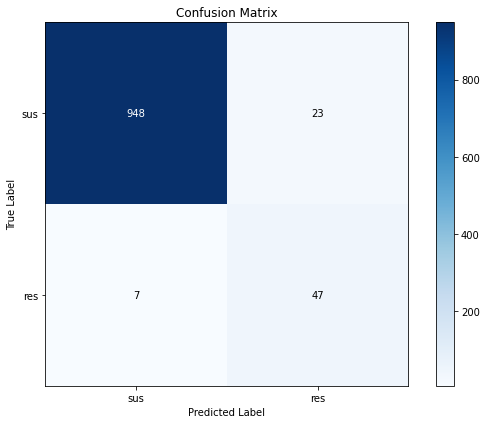

100%|██████████| 6904/6904 [00:28<00:00, 242.18it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.9565846599131693
Sensitivity (Recall): 0.8679245283018868
Specificity: 0.9639498432601881
F1 Score: 0.7540983606557377
AUC: 0.9358253977642396


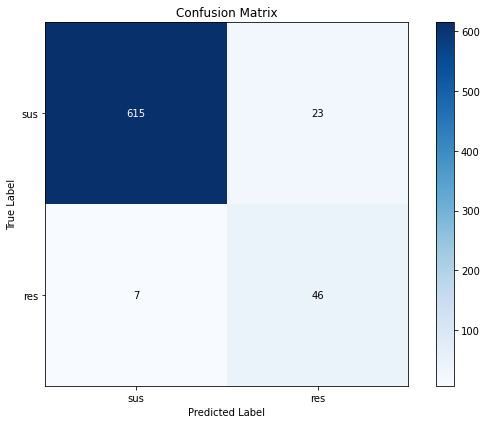

100%|██████████| 5976/5976 [00:21<00:00, 273.35it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.9782608695652174
Sensitivity (Recall): 0.8695652173913043
Specificity: 0.9873188405797102
F1 Score: 0.8602150537634409
AUC: 0.945730938878387


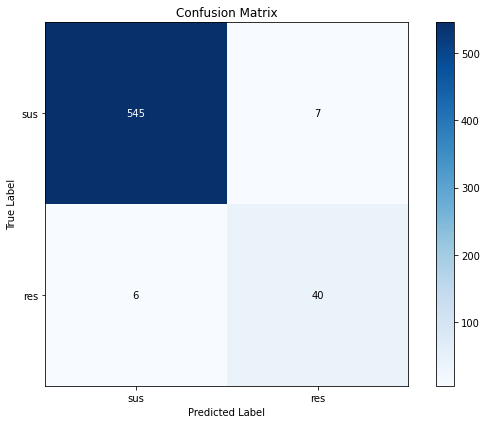

In [44]:
drug = 'MXF'
gene_list = ['gyrA', 'gyrB']
res_thresh = 1
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>4','4', '2', '1', '0.5', '0.25', '0.12', '<=0.06'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>4' :
        df_emb.loc[i, f'{x}'] = '8'
    elif row[x] == '<=0.06':
        df_emb.loc[i, f'{x}'] = '0.03'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 


cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## KAN

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/2050155109.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

Drugs: all
Accuracy: 0.9639423076923077
Sensitivity (Recall): 0.8732394366197183
Specificity: 0.9826086956521739
F1 Score: 0.8920863309352517
AUC: 0.9177179016125742


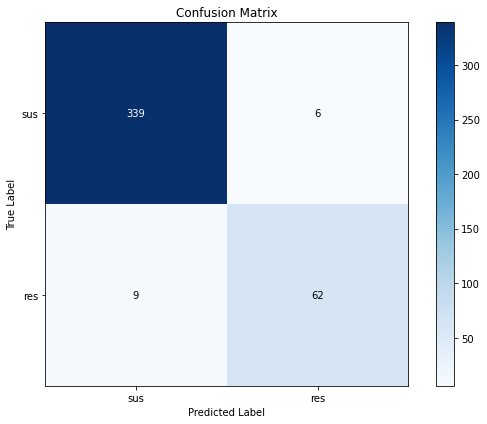

100%|██████████| 3987/3987 [00:07<00:00, 560.16it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.9824561403508771
Sensitivity (Recall): 0.9142857142857143
Specificity: 0.9969604863221885
F1 Score: 0.9481481481481482
AUC: 0.938145896656535


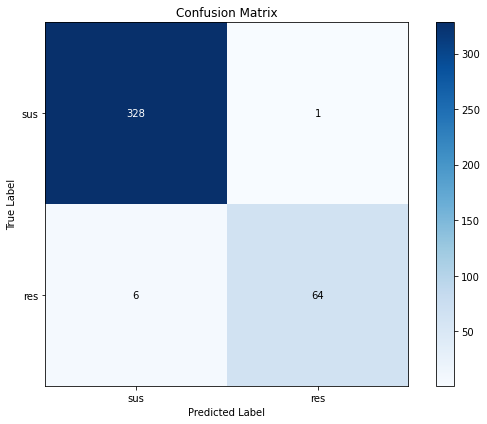

100%|██████████| 3557/3557 [00:06<00:00, 586.53it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.9775280898876404
Sensitivity (Recall): 0.8793103448275862
Specificity: 0.9966442953020134
F1 Score: 0.9272727272727272
AUC: 0.9268977088636889


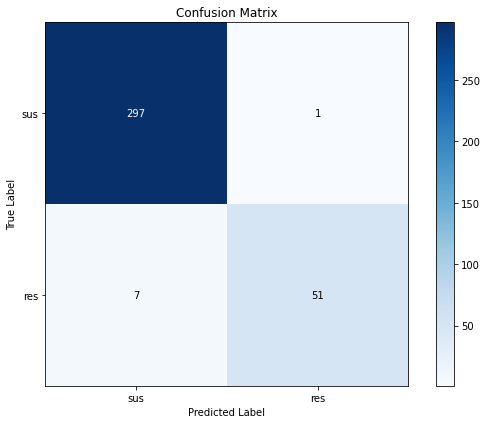

In [45]:
drug = 'KAN'
gene_list = ['rrs', 'tlyA', 'eis', 'gidB']
res_thresh = 4
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>16','16', '8', '4', '2', '<=1'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>16' :
        df_emb.loc[i, f'{x}'] = '32'
    elif row[x] == '<=1':
        df_emb.loc[i, f'{x}'] = '0.5'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh  else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh  else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh  else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## LEV

/tmp/ipykernel_1991/1346354490.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float')
100%|██████████| 11829/11829 [09:15<00:00, 21.31it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: all
Accuracy: 0.871513102282333
Sensitivity (Recall): 0.5740072202166066
Specificity: 0.9624724061810155
F1 Score: 0.6765957446808512
AUC: 0.8422490257489181


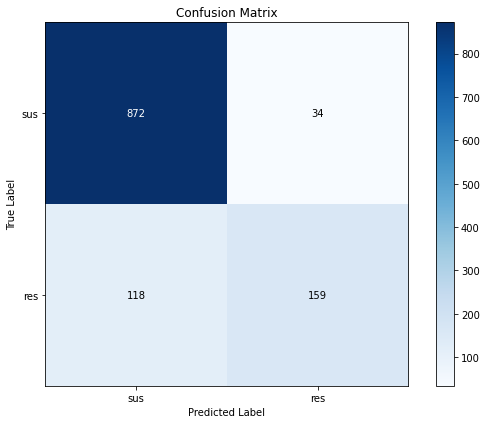

100%|██████████| 8828/8828 [05:16<00:00, 27.93it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.8788221970554927
Sensitivity (Recall): 0.5284090909090909
Specificity: 0.9660537482319661
F1 Score: 0.6348122866894198
AUC: 0.8795808152243796


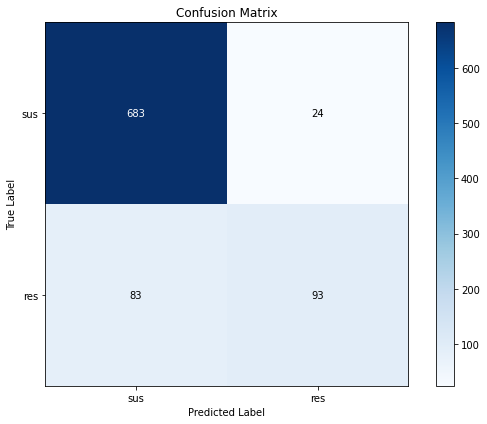

100%|██████████| 7661/7661 [04:00<00:00, 31.87it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.894393741851369
Sensitivity (Recall): 0.5579710144927537
Specificity: 0.9682034976152624
F1 Score: 0.6553191489361702
AUC: 0.866109075827746


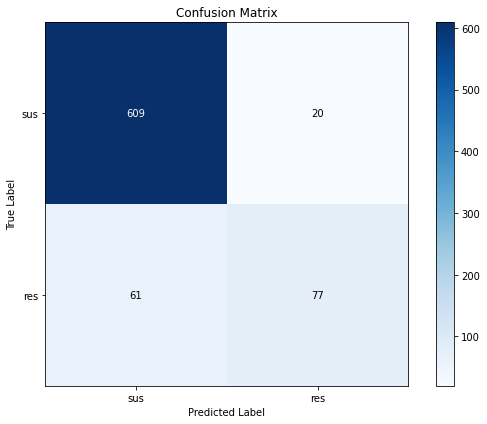

In [47]:
drug = 'LEV'
# gene_list = ['pgi', 'fadE4', 'php', 'cyp132', 'pckA', 'rpmB1', 'pfkB', 'acg', 'ctpF', 'cyp132', 'pckA', 'pfk']
gene_list = np.unique(variants['gene'])

res_thresh = 1
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.12'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.12':
        df_emb.loc[i, f'{x}'] = '0.06'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## LZD

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/3346402883.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

Drugs: all
Accuracy: 0.9606458123107972
Sensitivity (Recall): 0.0
Specificity: 0.9655172413793104
F1 Score: 0.0
AUC: 0.59026369168357


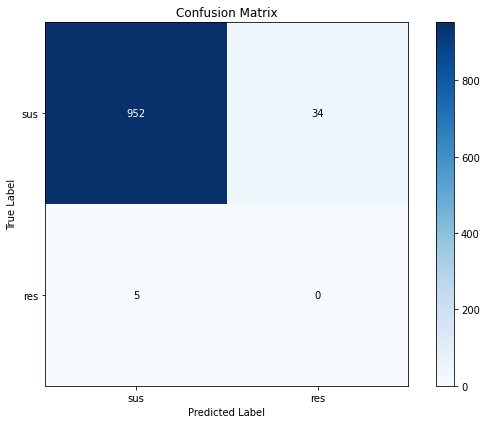

100%|██████████| 7277/7277 [00:22<00:00, 328.64it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.9848901098901099
Sensitivity (Recall): 0.25
Specificity: 0.988950276243094
F1 Score: 0.15384615384615383
AUC: 0.8914019337016575


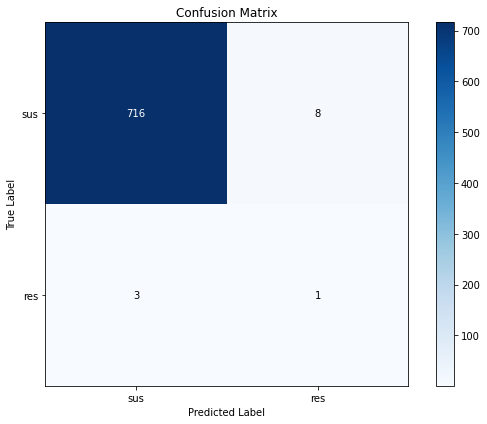

100%|██████████| 6234/6234 [00:16<00:00, 370.85it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.9935897435897436
Sensitivity (Recall): 0.75
Specificity: 0.9951612903225806
F1 Score: 0.6
AUC: 0.8955645161290323


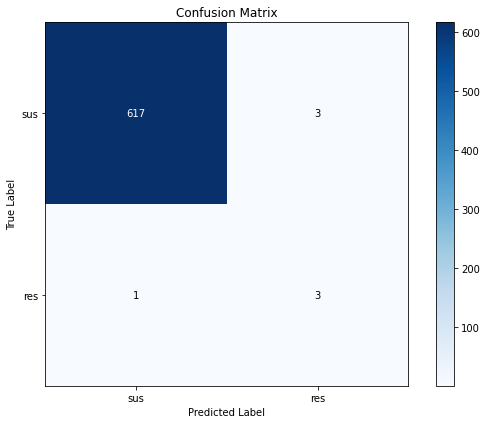

In [48]:
drug = 'LZD'
gene_list = ['rplC', 'rrl', 'rrs']
res_thresh = 1
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>2','2', '1', '0.5', '0.25', '0.12', '<=0.06'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>2' :
        df_emb.loc[i, f'{x}'] = '4'
    elif row[x] == '<=0.06':
        df_emb.loc[i, f'{x}'] = '0.03'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## AMI

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/1676804296.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

Drugs: all
Accuracy: 0.8976377952755905
Sensitivity (Recall): 0.35135135135135137
Specificity: 0.9563953488372093
F1 Score: 0.39999999999999997
AUC: 0.7853507577344786


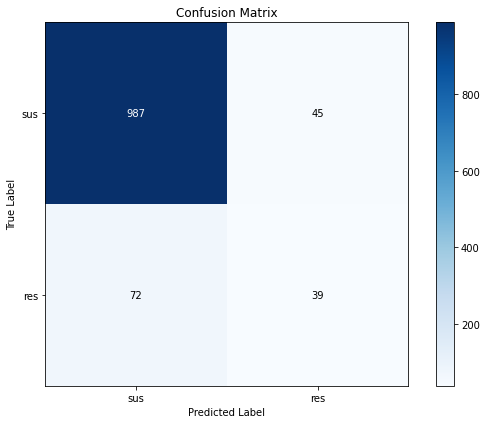

100%|██████████| 9729/9729 [06:15<00:00, 25.89it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.9362795477903392
Sensitivity (Recall): 0.22727272727272727
Specificity: 0.9878721058434399
F1 Score: 0.3260869565217391
AUC: 0.7330777454812736


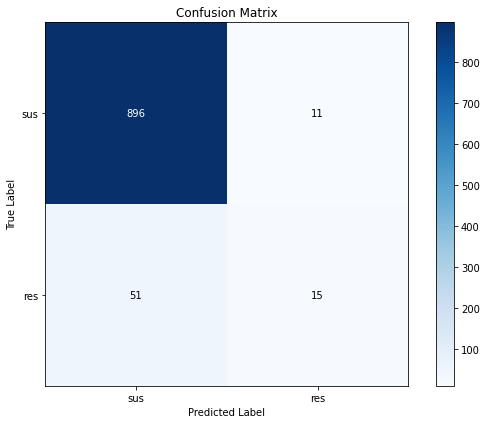

100%|██████████| 8629/8629 [04:52<00:00, 29.49it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.9548088064889919
Sensitivity (Recall): 0.29411764705882354
Specificity: 0.9963054187192119
F1 Score: 0.4347826086956522
AUC: 0.8043200038636144


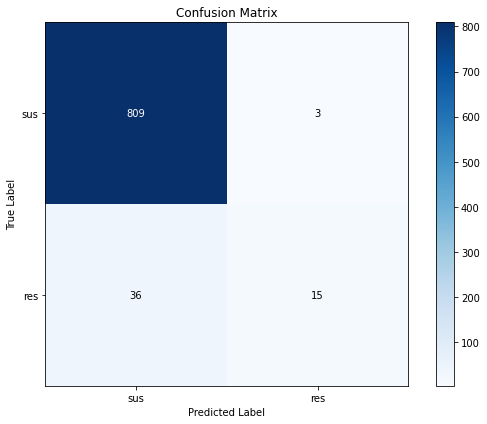

In [49]:
drug = 'AMI'
gene_list = np.unique(variants['gene'])
res_thresh = 1
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '<=0.25'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## BDQ


/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/620855364.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Drugs: all
Accuracy: 0.925531914893617
Sensitivity (Recall): 0.0
Specificity: 0.9456521739130435
F1 Score: 0.0
AUC: 0.3125


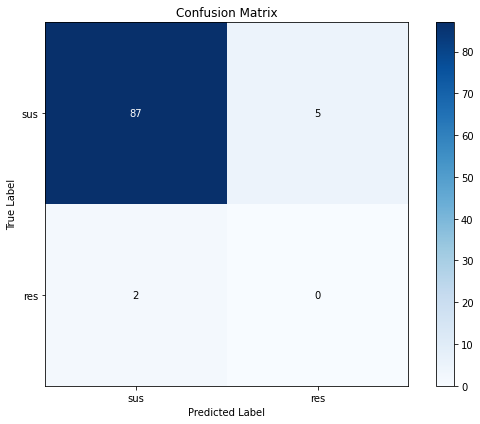

100%|██████████| 731/731 [00:00<00:00, 1162.34it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.9864864864864865
Sensitivity (Recall): 0.0
Specificity: 1.0
F1 Score: 0.0
AUC: 0.2465753424657534


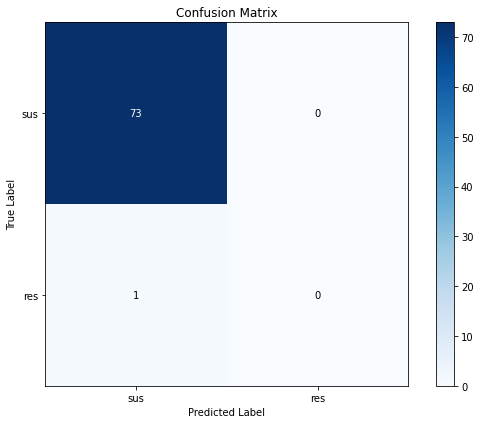

100%|██████████| 652/652 [00:00<00:00, 1054.52it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.9848484848484849
Sensitivity (Recall): 0.0
Specificity: 1.0
F1 Score: 0.0
AUC: 0.6230769230769231


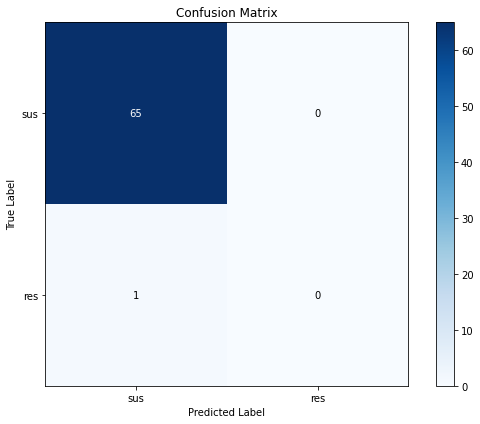

In [50]:
drug = 'BDQ'
gene_list = [ 'Rv0678', 'atpE', 'pepQ']
res_thresh = 0.25

df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>1', '1', '0.5', '0.25', '0.12', '0.06', '0.03', '<=0.015'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>1' :
        df_emb.loc[i, f'{x}'] = '2'
    elif row[x] == '<=0.015':
        df_emb.loc[i, f'{x}'] = '0.0075'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## CFZ

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/3473139116.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

Drugs: all
Accuracy: 0.7313195548489666
Sensitivity (Recall): 0.33766233766233766
Specificity: 0.8589473684210527
F1 Score: 0.380952380952381
AUC: 0.6622761449077238


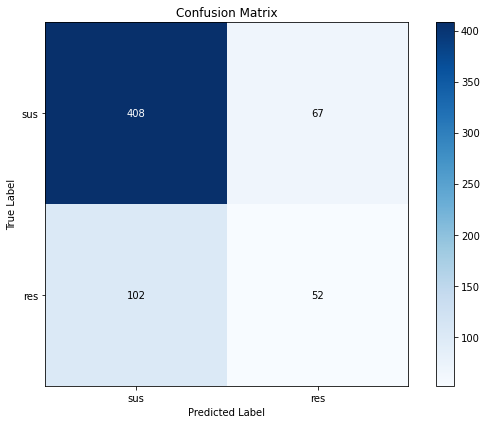

100%|██████████| 3803/3803 [00:57<00:00, 66.52it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.7926509186351706
Sensitivity (Recall): 0.21153846153846154
Specificity: 0.8844984802431611
F1 Score: 0.21782178217821782
AUC: 0.635229132569558


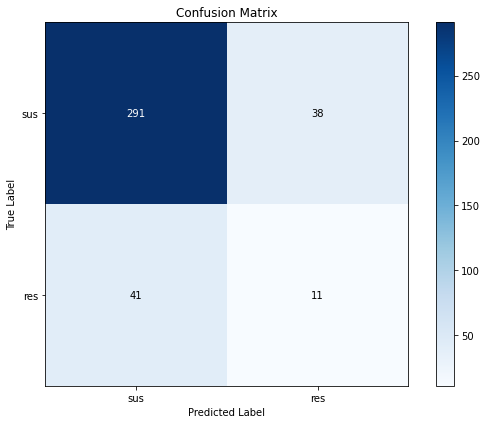

100%|██████████| 3302/3302 [00:43<00:00, 76.24it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.824773413897281
Sensitivity (Recall): 0.375
Specificity: 0.8865979381443299
F1 Score: 0.3409090909090909
AUC: 0.6859536082474227


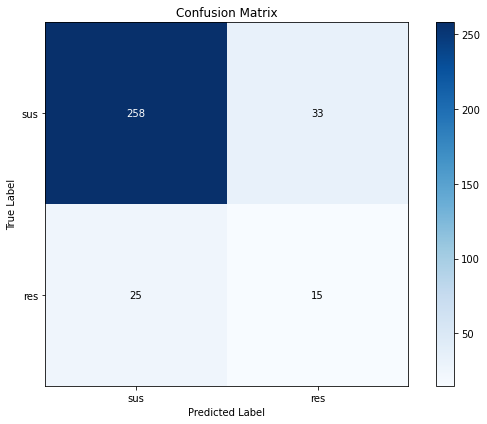

In [51]:
drug = 'CFZ'
gene_list = np.unique(variants['gene'])

res_thresh = 0.25
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>2','2', '1', '0.5', '0.25', '0.12', '0.06', '0.03', '<=0.015'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>2' :
        df_emb.loc[i, f'{x}'] = '4'
    elif row[x] == '<=0.015':
        df_emb.loc[i, f'{x}'] = '0.0075'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## DLM

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/tmp/ipykernel_1991/440987658.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Drugs: all
Accuracy: 0.9079320113314447
Sensitivity (Recall): 0.1111111111111111
Specificity: 0.9507462686567164
F1 Score: 0.1095890410958904
AUC: 0.6096393034825871


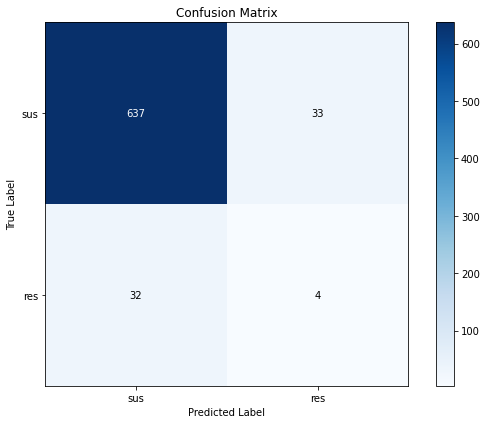

100%|██████████| 5612/5612 [02:04<00:00, 45.25it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low quality
Accuracy: 0.9590747330960854
Sensitivity (Recall): 0.08333333333333333
Specificity: 0.9781818181818182
F1 Score: 0.08
AUC: 0.49939393939393945


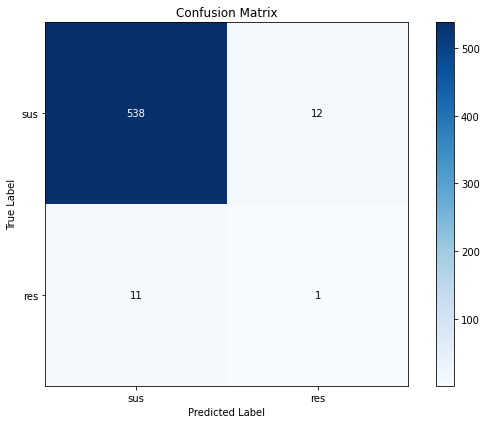

100%|██████████| 4728/4728 [01:28<00:00, 53.14it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Drugs: remove low and medium quality
Accuracy: 0.9513742071881607
Sensitivity (Recall): 0.09090909090909091
Specificity: 0.9718614718614719
F1 Score: 0.08
AUC: 0.5247933884297521


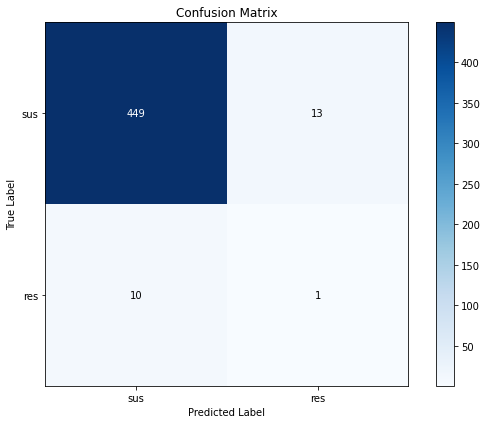

In [52]:
drug = 'DLM'
res_thresh = 0.12
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>0.5', '0.5', '0.25', '0.12', '0.06', '0.03', '<=0.015'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>0.5' :
        df_emb.loc[i, f'{x}'] = '1'
    elif row[x] == '<=0.015':
        df_emb.loc[i, f'{x}'] = '0.0075'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')

df_emb = df_emb[~df_emb[f'{drug}_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
encoded_mic = np.array([0 if value < res_thresh else 1 for value in mic_aa[f'{drug}_MIC'].to_list()])

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

# Multi level resistance classifier

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Initialize and train the RandomForestClassifier
def training_classifier(train_data, train_target, test_data, test_target, drug_name: str):
    clf = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=1000, class_weight="balanced")
    clf.fit(train_data, train_target)

    # Predict on the test data
    test_predictions = clf.predict(test_data)

    # Calculate accuracy
    accuracy = accuracy_score(test_target, test_predictions)
    print('Drugs:', drug_name)
    print("Accuracy:", accuracy)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(test_target, test_predictions)
    print("Confusion Matrix:\n", conf_matrix)

    # Calculate per-class sensitivity, specificity, and F1 score
    classes = np.unique(test_target)
    sensitivity = {}
    specificity = {}
    f1 = f1_score(test_target, test_predictions, average=None)
    auc = {}

    for i, class_label in enumerate(classes):
        tp = conf_matrix[i, i]
        fn = conf_matrix[i, :].sum() - tp
        fp = conf_matrix[:, i].sum() - tp
        tn = conf_matrix.sum() - (tp + fn + fp)

        sensitivity[class_label] = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity[class_label] = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Class {class_label}: Sensitivity (Recall): {sensitivity[class_label]}")
        print(f"Class {class_label}: Specificity: {specificity[class_label]}")
        print(f"Class {class_label}: F1 Score: {f1[i]}")

    # Binarize the test targets for AUC calculation
    test_target_binarized = label_binarize(test_target, classes=classes)
    test_pred_prob = clf.predict_proba(test_data)

    if len(classes) == 2:
        auc[classes[1]] = roc_auc_score(test_target, test_pred_prob[:, 1])
        print(f"AUC: {auc[classes[1]]}")
    else:
        for i, class_label in enumerate(classes):
            auc[class_label] = roc_auc_score(test_target_binarized[:, i], test_pred_prob[:, i])
            print(f"Class {class_label}: AUC: {auc[class_label]}")

    # Plot confusion matrix using Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Labeling the plot
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Loop over data dimensions and create text annotations.
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


# Three level resistance

## To be dropped

In [6]:
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]


# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

variants = pd.read_csv('variants_full.csv')

# variants[~variants['drugs'].isna()]
emb_val = variants[variants['drugs']=='ethambutol']

discordance = []
discordance_values = []
_4_with_resistance = 0
_4_without_resistance = 0
to_be_dropped = []
for i, row in tqdm(mic_aa.iterrows()):
    x = 'EMB_MIC'
    # print(row[x])
    if row[x] <= 16:
        if row['ENA_RUN'] in emb_val['sample_id'].to_list():
            # print('<4', row['ENA_RUN'], row[x])
            # discordance.append(row['ENA_RUN'])
            discordance_values.append(row[x])            
    if row[x] ==0.25 or row[x] ==0.125 or row[x]==0.500 or row[x]==1:
        if row['ENA_RUN'] in emb_val['sample_id'].to_list():
            # print('=4', row['ENA_RUN'], row[x])
            _4_with_resistance += 1
            to_be_dropped.append(row['ENA_RUN'])
        else:
            _4_without_resistance += 1
    # elif pd.isna(row[x]):
    #     if row['ENA_RUN'] in emb_val['sample_id'].to_list():
    #         print('NaN', row['ENA_RUN'], row[x])  
    else:
        if row['ENA_RUN'] in emb_val['sample_id'].to_list():
            # print('>4', row['ENA_RUN'], row[x])
            pass
print(_4_with_resistance, '/', _4_without_resistance+ _4_with_resistance)

/tmp/ipykernel_89209/2372552675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_89209/2372552675.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.125'
/tmp/ipykernel_89209/2372552675.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float')
100%|████████

231 / 5191


### EMB

/tmp/ipykernel_89209/1797720341.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_89209/1797720341.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.125'
/tmp/ipykernel_89209/1797720341.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float')
100%|████████

Drugs: all
Accuracy: 0.8532751091703057
Confusion Matrix:
 [[770  28  15]
 [ 30  83  36]
 [ 11  48 124]]
Class 0: Sensitivity (Recall): 0.947109471094711
Class 0: Specificity: 0.8765060240963856
Class 0: F1 Score: 0.9482758620689656
Class 1: Sensitivity (Recall): 0.5570469798657718
Class 1: Specificity: 0.9236947791164659
Class 1: F1 Score: 0.5389610389610389
Class 2: Sensitivity (Recall): 0.6775956284153005
Class 2: Specificity: 0.946985446985447
Class 2: F1 Score: 0.6927374301675977
Class 0: AUC: 0.9223906696898295
Class 1: AUC: 0.8151667070968438
Class 2: AUC: 0.9076036944889404


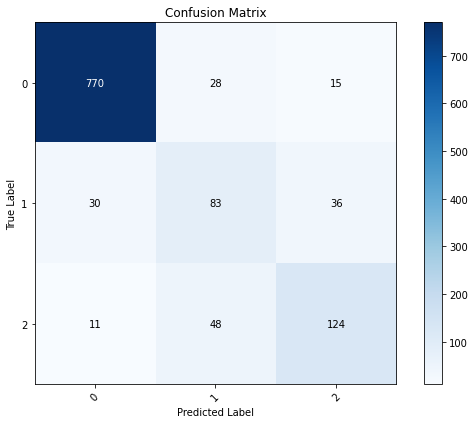

100%|██████████| 8334/8334 [00:30<00:00, 269.95it/s]
/tmp/ipykernel_89209/2072411084.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_89209/2072411084.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())


Drugs: remove low quality
Accuracy: 0.815347721822542
Confusion Matrix:
 [[534  26  16]
 [ 25  54  31]
 [  8  48  92]]
Class 0: Sensitivity (Recall): 0.9270833333333334
Class 0: Specificity: 0.872093023255814
Class 0: F1 Score: 0.9343832020997376
Class 1: Sensitivity (Recall): 0.4909090909090909
Class 1: Specificity: 0.8977900552486188
Class 1: F1 Score: 0.45378151260504196
Class 2: Sensitivity (Recall): 0.6216216216216216
Class 2: Specificity: 0.9314868804664723
Class 2: F1 Score: 0.6411149825783972
Class 0: AUC: 0.9161317021963824
Class 1: AUC: 0.7724510296333501
Class 2: AUC: 0.9192193286581042


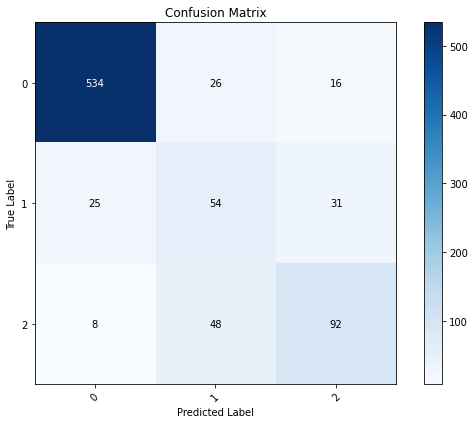

100%|██████████| 7223/7223 [00:23<00:00, 307.23it/s]
/tmp/ipykernel_89209/2072411084.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_89209/2072411084.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())


Drugs: remove low and medium quality
Accuracy: 0.8506224066390041
Confusion Matrix:
 [[477  17  11]
 [ 19  46  23]
 [  4  34  92]]
Class 0: Sensitivity (Recall): 0.9445544554455445
Class 0: Specificity: 0.8944954128440367
Class 0: F1 Score: 0.9492537313432836
Class 1: Sensitivity (Recall): 0.5227272727272727
Class 1: Specificity: 0.9196850393700787
Class 1: F1 Score: 0.49729729729729727
Class 2: Sensitivity (Recall): 0.7076923076923077
Class 2: Specificity: 0.9426644182124789
Class 2: F1 Score: 0.7187500000000001
Class 0: AUC: 0.9357298573894086
Class 1: AUC: 0.829438081603436
Class 2: AUC: 0.9113698274743806


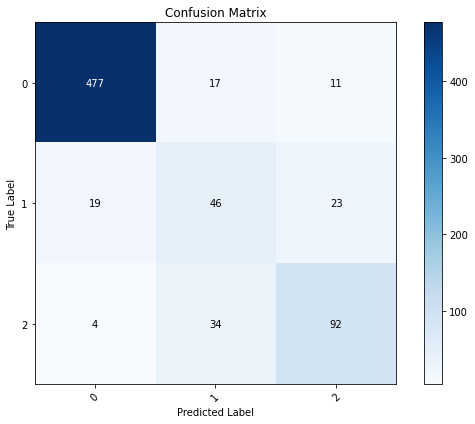

In [9]:
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]

# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = []
for value in mic_aa['EMB_MIC'].to_list():
    if value <= 2:
        encoded_mic.append(0)
    elif value > 4:
        encoded_mic.append(2)
    else:
        encoded_mic.append(1)
        
train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'all')

df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = []
for value in mic_aa['EMB_MIC'].to_list():
    if value <= 2:
        encoded_mic.append(0)
    elif value > 4:
        encoded_mic.append(2)
    else:
        encoded_mic.append(1)
        
train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low quality')


df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])]  # remove low and med quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

encoded_mic = []
for value in mic_aa['EMB_MIC'].to_list():
    if value <= 2:
        encoded_mic.append(0)
    elif value > 4:
        encoded_mic.append(2)
    else:
        encoded_mic.append(1)
        
train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
training_classifier(train_data, train_target, test_data, test_target, 'remove low and medium quality')

## EMB_test

In [ ]:
train_data, test_data, train_target, test_target  = data_split(aa_array, np.log2(mic_aa['EMB_MIC']))
train_data, val_data, train_target, val_target  = data_split(train_data, train_target)

In [82]:
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]


# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])]  # remove low and med quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

encoded_mic = []
for value in mic_aa['EMB_MIC'].to_list():
    if value <= 2:
        encoded_mic.append(0)
    elif value > 4:
        encoded_mic.append(2)
    else:
        encoded_mic.append(1)
        
train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
train_data, val_data, train_target, val_target  = data_split(train_data, train_target)


100%|██████████| 7100/7100 [00:24<00:00, 286.64it/s]


In [292]:
mic_aa['ENA_RUN']

7116     ERR4829684
10471    ERR8975196
5432     ERR3287611
6498     ERR4828904
8217     ERR4831761
            ...    
4028     ERR4812175
3283     ERR4797355
3916     ERR4811968
7724     ERR2510245
3047     ERR4797048
Name: ENA_RUN, Length: 11445, dtype: category
Categories (11445, object): ['ERR4829684', 'ERR8975196', 'ERR3287611', 'ERR4828904', ..., 'ERR4797355', 'ERR4811968', 'ERR2510245', 'ERR4797048']

In [293]:
# def data_split_id(aa_array, encoded_mic, sample_ids):
#     """
#     Split the data into training and testing sets, ensuring the sample IDs are split accordingly.
    
#     Parameters:
#     aa_array (array-like): The input data array.
#     encoded_mic (array-like): The encoded target variable.
#     sample_ids (array-like): The list of sample IDs.
    
#     Returns:
#     train_data (array-like): Training data.
#     test_data (array-like): Testing data.
#     train_target (array-like): Training target.
#     test_target (array-like): Testing target.
#     train_ids (array-like): Training sample IDs.
#     test_ids (array-like): Testing sample IDs.
#     """
#     # Perform stratified train-test split
#     train_data, test_data, train_target, test_target, train_ids, test_ids = train_test_split(
#         aa_array,
#         encoded_mic,
#         sample_ids,
#         test_size=0.1,  # 10% for testing
#         stratify=encoded_mic,  # Ensures the proportion of each class is preserved
#         random_state=42  # For reproducibility
#     )
    
#     return train_data, test_data, train_target, test_target, train_ids, test_ids


def data_split_id(aa_array, mic_series, sample_ids):
    """
    Splits the data into training and testing sets while keeping sample IDs.

    Parameters:
    aa_array (np.ndarray): Feature array.
    mic_series (pd.Series): Target variable.
    sample_ids (pd.Series): Sample IDs.

    Returns:
    tuple: Training data, testing data, training target, testing target, training IDs, testing IDs.
    """
    # Encode the target variable if necessary (not shown here)

    # Perform stratified train-test split
    train_data, test_data, train_target, test_target, train_id, test_id = train_test_split(
        aa_array,
        mic_series,
        sample_ids,
        test_size=0.1,  # 10% for testing
        stratify=mic_series,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target, train_id, test_id


In [295]:
encoded_mic = []
for value in mic_aa['EMB_MIC'].to_list():
    if value <= 2:
        encoded_mic.append(0)
    elif value > 4:
        encoded_mic.append(2)
    else:
        encoded_mic.append(1)
        
train_data, test_data, train_target, test_target, train_ids, test_ids  = data_split_id(aa_array, encoded_mic, mic_aa['ENA_RUN'])
train_data, val_data, train_target, val_target,  train_ids, val_ids = data_split_id(train_data, train_target, train_ids)

Accuracy: 0.851528384279476
Confusion Matrix:
 [[771  27  15]
 [ 31  83  35]
 [ 11  51 121]]
Class 0: Sensitivity (Recall): 0.948339483394834
Class 0: Specificity: 0.8734939759036144
Class 0: F1 Score: 0.948339483394834
Class 1: Sensitivity (Recall): 0.5570469798657718
Class 1: Specificity: 0.9216867469879518
Class 1: F1 Score: 0.535483870967742
Class 2: Sensitivity (Recall): 0.6612021857923497
Class 2: Specificity: 0.9480249480249481
Class 2: F1 Score: 0.6836158192090396
Class 0: AUC: 0.9216830421316262
Class 1: AUC: 0.8084451901565997
Class 2: AUC: 0.9042721788623427


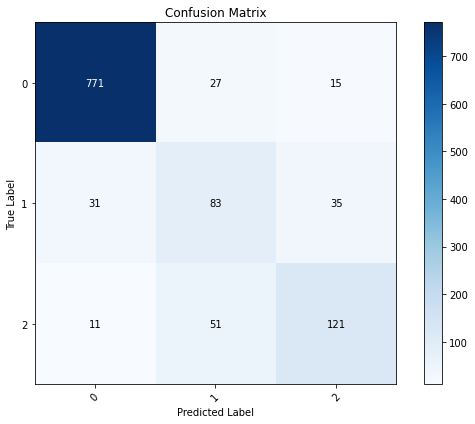

In [296]:
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# Assuming train_data, train_target, test_data, and val_target are already defined

# Initialize the RandomForestRegressor
# clf = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=1000, class_weight="balanced")
clf = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=1000, class_weight='balanced_subsample')
# clf = BalancedRandomForestClassifier(n_estimators=1000, max_depth=100, random_state=0)
# clf = EasyEnsembleClassifier(n_estimators=1000)
clf.fit(train_data, train_target)

# Predict on the test data
test_predictions = clf.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_target, test_predictions)
# print('Drugs:', drug_name)
print("Accuracy:", accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_target, test_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Calculate per-class sensitivity, specificity, and F1 score
classes = np.unique(test_target)
sensitivity = {}
specificity = {}
f1 = f1_score(test_target, test_predictions, average=None)
auc = {}

for i, class_label in enumerate(classes):
    tp = conf_matrix[i, i]
    fn = conf_matrix[i, :].sum() - tp
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (tp + fn + fp)

    sensitivity[class_label] = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity[class_label] = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Class {class_label}: Sensitivity (Recall): {sensitivity[class_label]}")
    print(f"Class {class_label}: Specificity: {specificity[class_label]}")
    print(f"Class {class_label}: F1 Score: {f1[i]}")

# Binarize the test targets for AUC calculation
test_target_binarized = label_binarize(test_target, classes=classes)
test_pred_prob = clf.predict_proba(test_data)

if len(classes) == 2:
    auc[classes[1]] = roc_auc_score(test_target, test_pred_prob[:, 1])
    print(f"AUC: {auc[classes[1]]}")
else:
    for i, class_label in enumerate(classes):
        auc[class_label] = roc_auc_score(test_target_binarized[:, i], test_pred_prob[:, i])
        print(f"Class {class_label}: AUC: {auc[class_label]}")

# Plot confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Loop over data dimensions and create text annotations.
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


### Error analysis

In [ ]:
from sklearn.metrics import accuracy_score

# Example data
# test_data = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]])
# val_target = np.array([0, 1, 1, 0])  # Example actual resistance levels
# test_predictions = np.array([0, 0, 1, 1])  # Example predictions by the model

# Predict on the test data
# Note: Uncomment the following line in actual use case
test_predictions = clf.predict(val_data)

# Calculate accuracy
# accuracy = accuracy_score(test_target, test_predictions)
# print(f'Accuracy: {accuracy * 100:.2f}%')

# Output erroneous predictions
print("Erroneous Predictions:")
for i, (actual, predicted) in enumerate(zip(val_target, test_predictions)):
    if actual != predicted:
        print(f"Sample {i}: Actual = {actual}, Predicted = {predicted}")

# Example actual resistance levels and predictions
resistance_levels = ["Susceptible", "Intermediate", "Resistant"]

res_high_pred_mid = []
res_high_pred_low = []
res_mid_pred_low = []
res_mid_pred_high = []
res_low_pred_mid = []
res_low_pred_high = []

# Output erroneous predictions with specific resistance levels
# print("\nDetailed Erroneous Predictions:")
for i, (actual, predicted, id) in enumerate(zip(val_target, test_predictions, val_ids)):
    if actual != predicted:
        actual_resistance = resistance_levels[actual]
        predicted_resistance = resistance_levels[predicted]
        # print(f"Sample {i}: Actual Resistance = {actual_resistance}, Predicted Resistance = {predicted_resistance}")
        if actual == 2 and predicted == 1:
            res_high_pred_mid.append(id)
        elif actual == 2 and predicted == 0:
            res_high_pred_low.append(id)
        elif actual == 1 and predicted == 0:
            res_mid_pred_low.append(id)
        elif actual == 1 and predicted == 2:
            res_mid_pred_high.append(id)
        elif actual == 0 and predicted == 1:
            res_low_pred_mid.append(id)
        elif actual == 0 and predicted == 2:
            res_low_pred_high.append(id)
        else:
            pass        


In [309]:
emb_snp

In [369]:
emb_val = variants[variants['drugs']=='ethambutol']
emb_snp = variants[variants['gene'].isin(['embA','embB','embC'])]
emb_snp = emb_snp[~emb_snp['type'].isin(['synonymous_variant', 'non_coding_transcript_exon_variant'])]
emb_snp = variants[~variants['sample_id'].isin(emb_val['sample_id'])]
emb_snp = emb_snp[~emb_snp['type'].isin(['synonymous_variant','non_coding_transcript_exon_variant'])]

In [372]:
variants = pd.read_csv('variants_full.csv')

# variants[~variants['drugs'].isna()]
emb_val = variants[variants['drugs']=='ethambutol']

drug_snp = []
no_snp = []
mid = []

for row in res_high_pred_low:
    if row in emb_val['sample_id'].to_list():
        # print('<4', row, row[x])
        # discordance.append(row)
        drug_snp.append(row)            

    elif row in emb_snp['sample_id'].to_list():
        # print('=4', row, row[x])
        # _4_with_resistance += 1
        mid.append(row)
    else:
        no_snp.append(row)
    # elif pd.isna(row[x]):
    #     if row in emb_val['sample_id'].to_list():
    #         print('NaN', row, row[x])  
    # else:
    #     if row in emb_val['sample_id'].to_list():
    #         # print('>4', row, row[x])
    #         pass
print('drug_snp')
print(drug_snp)
print('no_snp')
print(no_snp)
print('mid')
print(mid)

drug_snp
['ERR8975801', 'ERR3287857', 'ERR4829975', 'ERR4811085', 'ERR4797409', 'ERR3287349', 'ERR8975017', 'ERR4811163']
no_snp
[]
mid
['ERR4796614', 'ERR4797746', 'ERR2510567', 'ERR4811646']


In [373]:
variants = pd.read_csv('variants_full.csv')

# variants[~variants['drugs'].isna()]
emb_val = variants[variants['drugs']=='ethambutol']

drug_snp = []
no_snp = []
mid = []

for row in res_high_pred_mid:
    if row in emb_val['sample_id'].to_list():
        # print('<4', row, row[x])
        # discordance.append(row)
        drug_snp.append(row)            

    elif row in emb_snp['sample_id'].to_list():
        # print('=4', row, row[x])
        # _4_with_resistance += 1
        mid.append(row)
    else:
        no_snp.append(row)
    # elif pd.isna(row[x]):
    #     if row in emb_val['sample_id'].to_list():
    #         print('NaN', row, row[x])  
    # else:
    #     if row in emb_val['sample_id'].to_list():
    #         # print('>4', row, row[x])
    #         pass
print('drug_snp')
print(drug_snp)
print('no_snp')
print(no_snp)
print('mid')
print(mid)

drug_snp
['ERR8975006', 'ERR4808903', 'ERR5918112', 'ERR2510426', 'ERR4809269', 'ERR4808857', 'ERR8975796', 'ERR3287541', 'ERR4831599', 'ERR4810843', 'ERR4809007', 'ERR4809270', 'ERR4830821', 'ERR3287843', 'ERR4831777', 'ERR5917976', 'ERR2510416', 'ERR4797402', 'ERR8665842', 'ERR4797612', 'ERR4831943', 'ERR4809281', 'ERR4809255', 'ERR4832019', 'ERR4829728', 'ERR4811158', 'ERR4810471', 'ERR2510404', 'ERR4796613', 'ERR4808864', 'ERR4831880', 'ERR3287522', 'ERR4831242', 'ERR4810868', 'ERR3287621', 'ERR8975061', 'ERR4829959', 'ERR4813865', 'ERR4797175', 'ERR2510496', 'ERR4828783', 'ERR4810953', 'ERR5918046']
no_snp
[]
mid
['ERR4831938']


In [374]:
variants = pd.read_csv('variants_full.csv')

# variants[~variants['drugs'].isna()]
emb_val = variants[variants['drugs']=='ethambutol']

drug_snp = []
no_snp = []
mid = []

for row in res_mid_pred_high:
    if row in emb_val['sample_id'].to_list():
        # print('<4', row, row[x])
        # discordance.append(row)
        drug_snp.append(row)            

    elif row in emb_snp['sample_id'].to_list():
        # print('=4', row, row[x])
        # _4_with_resistance += 1
        mid.append(row)
    else:
        no_snp.append(row)
    # elif pd.isna(row[x]):
    #     if row in emb_val['sample_id'].to_list():
    #         print('NaN', row, row[x])  
    # else:
    #     if row in emb_val['sample_id'].to_list():
    #         # print('>4', row, row[x])
    #         pass
print('drug_snp')
print(drug_snp)
print('no_snp')
print(no_snp)
print('mid')
print(mid)

drug_snp
['ERR4830598', 'ERR4822405', 'ERR4830865', 'ERR4830585', 'ERR4830842', 'ERR4830651', 'ERR4830919', 'ERR4830981', 'ERR4830597', 'ERR4822418', 'ERR4822375', 'ERR4829366', 'ERR4822590', 'ERR4829391', 'ERR4831953', 'ERR4830161', 'ERR4831009', 'ERR4796672', 'ERR4812946', 'ERR4822591', 'ERR4829401', 'ERR4830958', 'ERR2510449', 'ERR4797836', 'ERR4828227', 'ERR4797209', 'ERR4797014', 'ERR4822297', 'ERR4822318', 'ERR2510466', 'ERR4812872', 'ERR4813435', 'ERR4796588', 'ERR4830968', 'ERR2510705', 'ERR4813179', 'ERR4831425', 'ERR4830143', 'ERR3287723', 'ERR4829125']
no_snp
[]
mid
[]


In [375]:
variants = pd.read_csv('variants_full.csv')

# variants[~variants['drugs'].isna()]
emb_val = variants[variants['drugs']=='ethambutol']

drug_snp = []
no_snp = []
mid = []

for row in res_mid_pred_low:
    if row in emb_val['sample_id'].to_list():
        # print('<4', row, row[x])
        # discordance.append(row)
        drug_snp.append(row)            

    elif row in emb_snp['sample_id'].to_list():
        # print('=4', row, row[x])
        # _4_with_resistance += 1
        mid.append(row)
    else:
        no_snp.append(row)
    # elif pd.isna(row[x]):
    #     if row in emb_val['sample_id'].to_list():
    #         print('NaN', row, row[x])  
    # else:
    #     if row in emb_val['sample_id'].to_list():
    #         # print('>4', row, row[x])
    #         pass
print('drug_snp')
print(drug_snp)
print('no_snp')
print(no_snp)
print('mid')
print(mid)

drug_snp
['ERR4831931', 'ERR4796867', 'ERR4797052', 'ERR4797711', 'ERR4831632', 'ERR4796347', 'ERR4830623']
no_snp
[]
mid
['ERR4797202', 'ERR4831800', 'ERR3287592', 'ERR4830764', 'ERR4811510', 'ERR8975630', 'ERR4809282', 'ERR2510590', 'ERR4810728', 'ERR4797129', 'ERR8975043', 'ERR4811013', 'ERR4813775', 'ERR4828433', 'ERR8975925', 'ERR8699813', 'ERR4831780', 'ERR3287497', 'ERR4810780', 'ERR8699795', 'ERR4829584', 'ERR4797706', 'ERR4828439', 'ERR8699730', 'ERR4810771', 'ERR8700365']


In [376]:
variants = pd.read_csv('variants_full.csv')

# variants[~variants['drugs'].isna()]
emb_val = variants[variants['drugs']=='ethambutol']

drug_snp = []
no_snp = []
mid = []

for row in res_low_pred_high:
    if row in emb_val['sample_id'].to_list():
        # print('<4', row, row[x])
        # discordance.append(row)
        drug_snp.append(row)            

    elif row in emb_snp['sample_id'].to_list():
        # print('=4', row, row[x])
        # _4_with_resistance += 1
        mid.append(row)
    else:
        no_snp.append(row)
    # elif pd.isna(row[x]):
    #     if row in emb_val['sample_id'].to_list():
    #         print('NaN', row, row[x])  
    # else:
    #     if row in emb_val['sample_id'].to_list():
    #         # print('>4', row, row[x])
    #         pass
print('drug_snp')
print(drug_snp)
print('no_snp')
print(no_snp)
print('mid')
print(mid)

drug_snp
['ERR4830941', 'ERR4813447', 'ERR4822406', 'ERR4797705', 'ERR4822313', 'ERR4812835', 'ERR4812768', 'ERR4830553', 'ERR4831489', 'ERR4797592', 'ERR4812875', 'ERR4828724', 'ERR4797562', 'ERR4831257']
no_snp
[]
mid
[]


In [377]:
variants = pd.read_csv('variants_full.csv')

# variants[~variants['drugs'].isna()]
emb_val = variants[variants['drugs']=='ethambutol']

drug_snp = []
no_snp = []
mid = []

for row in res_low_pred_mid:
    if row in emb_val['sample_id'].to_list():
        # print('<4', row, row[x])
        # discordance.append(row)
        drug_snp.append(row)            

    elif row in emb_snp['sample_id'].to_list():
        # print('=4', row, row[x])
        # _4_with_resistance += 1
        mid.append(row)
    else:
        no_snp.append(row)
    # elif pd.isna(row[x]):
    #     if row in emb_val['sample_id'].to_list():
    #         print('NaN', row, row[x])  
    # else:
    #     if row in emb_val['sample_id'].to_list():
    #         # print('>4', row, row[x])
    #         pass
print('drug_snp')
print(drug_snp)
print('no_snp')
print(no_snp)
print('mid')
print(mid)

drug_snp
['ERR5917664', 'ERR4812375', 'ERR4830023', 'ERR4831467', 'ERR4812062', 'ERR8975025', 'ERR3287414', 'ERR4828985', 'ERR4828780', 'ERR4812964', 'ERR4830609', 'ERR4797854', 'ERR4830124', 'ERR2510326', 'ERR4828857', 'ERR8665883', 'ERR4830500', 'ERR4812955', 'ERR2510606', 'ERR2510856', 'ERR4828834', 'ERR4830606', 'ERR8665864', 'ERR4812697', 'ERR3287687', 'ERR5917752', 'ERR8665930', 'ERR4831426', 'ERR4822381', 'ERR2510688']
no_snp
[]
mid
['ERR4831607']


In [378]:
variants = pd.read_csv('variants_full.csv')

# variants[~variants['drugs'].isna()]
emb_val = variants[variants['drugs']=='ethambutol']

drug_snp = []
no_snp = []
mid = []

for row in res_low_pred_high:
    if row in emb_snp['sample_id'].to_list():
        # print('<4', row, row[x])
        # discordance.append(row)
        drug_snp.append(row)            

    elif row in emb_val['sample_id'].to_list():
        # print('=4', row, row[x])
        # _4_with_resistance += 1
        mid.append(row)
    else:
        no_snp.append(row)
    # elif pd.isna(row[x]):
    #     if row in emb_val['sample_id'].to_list():
    #         print('NaN', row, row[x])  
    # else:
    #     if row in emb_val['sample_id'].to_list():
    #         # print('>4', row, row[x])
    #         pass
print('drug_snp')
print(drug_snp)
print('no_snp')
print(no_snp)
print('mid')
print(mid)

drug_snp
[]
no_snp
[]
mid
['ERR4830941', 'ERR4813447', 'ERR4822406', 'ERR4797705', 'ERR4822313', 'ERR4812835', 'ERR4812768', 'ERR4830553', 'ERR4831489', 'ERR4797592', 'ERR4812875', 'ERR4828724', 'ERR4797562', 'ERR4831257']


In [92]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_target), y=train_target)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
sample_weights = np.array([class_weights_dict[class_label] for class_label in train_target])


In [98]:
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.utils.class_weight import compute_class_weight

# Assuming train_data, train_target, test_data, and val_target are already defined
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_target), y=train_target)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
sample_weights = np.array([class_weights_dict[class_label] for class_label in train_target])

# Initialize the RandomForestRegressor
# clf = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=1000, class_weight="balanced")
clf =  xgb.XGBRFClassifier(max_depth=100, random_state=0, n_estimators=1000)
# clf = BalancedRandomForestClassifier(n_estimators=1000, max_depth=100, random_state=0)
# clf = EasyEnsembleClassifier(n_estimators=1000)
clf.fit(train_data, train_target, sample_weight=sample_weights)


# Predict on the test data
test_predictions = clf.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_target, test_predictions)
# print('Drugs:', drug_name)
print("Accuracy:", accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_target, test_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Calculate per-class sensitivity, specificity, and F1 score
classes = np.unique(test_target)
sensitivity = {}
specificity = {}
f1 = f1_score(test_target, test_predictions, average=None)
auc = {}

for i, class_label in enumerate(classes):
    tp = conf_matrix[i, i]
    fn = conf_matrix[i, :].sum() - tp
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (tp + fn + fp)

    sensitivity[class_label] = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity[class_label] = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Class {class_label}: Sensitivity (Recall): {sensitivity[class_label]}")
    print(f"Class {class_label}: Specificity: {specificity[class_label]}")
    print(f"Class {class_label}: F1 Score: {f1[i]}")

# Binarize the test targets for AUC calculation
test_target_binarized = label_binarize(test_target, classes=classes)
test_pred_prob = clf.predict_proba(test_data)

if len(classes) == 2:
    auc[classes[1]] = roc_auc_score(test_target, test_pred_prob[:, 1])
    print(f"AUC: {auc[classes[1]]}")
else:
    for i, class_label in enumerate(classes):
        auc[class_label] = roc_auc_score(test_target_binarized[:, i], test_pred_prob[:, i])
        print(f"Class {class_label}: AUC: {auc[class_label]}")

# Plot confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Loop over data dimensions and create text annotations.
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [7]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(train_data, test_data, train_target, test_target)
print(models)

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


NameError: name 'train_data' is not defined

# Regression

In [47]:

df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]

# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])]  # remove low and med quality
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

encoded_mic = mic_aa['EMB_MIC'].to_list()

train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)

100%|██████████| 7114/7114 [00:24<00:00, 290.56it/s]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming train_data, train_target, test_data, and test_target are already defined

# Initialize the RandomForestRegressor
regressor = RandomForestRegressor(max_depth=100, random_state=0, n_estimators=1000)
regressor.fit(train_data, train_target)

# Predict on the test data
test_predictions = regressor.predict(test_data)

# Calculate regression metrics
mae = mean_absolute_error(test_target, test_predictions)
mse = mean_squared_error(test_target, test_predictions)
r2 = r2_score(test_target, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Calculate residuals
residuals = test_target - test_predictions

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test_target, test_predictions, edgecolors=(0, 0, 0))
plt.plot([np.min(test_target), np.max(test_target)], [np.min(test_target), np.max(test_target)], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(test_predictions, residuals, edgecolors=(0, 0, 0))
plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()


### Doubling dilution accuracy

### rf

In [50]:
value_counts_list(train_target)

{0: 5754, 2: 1331, 1: 1088}

In [ ]:
train_data, val_data, train_target, val_target  = data_split(train_data, train_target)

### predicting regressor for three level resistance

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming train_data, train_target, test_data, and test_target are already defined

# Initialize the RandomForestRegressor
regressor = RandomForestRegressor(max_depth=100, random_state=0, n_estimators=1000)
regressor.fit(train_data, train_target)

# Predict on the test data
test_predictions = regressor.predict(test_data)

# Calculate regression metrics
mae = mean_absolute_error(test_target, test_predictions)
mse = mean_squared_error(test_target, test_predictions)
r2 = r2_score(test_target, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target):
    _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5]
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(test_predictions, test_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate residuals
# residuals = test_target - test_predictions

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(test_target, test_predictions, edgecolors=(0, 0, 0))
# plt.plot([test_target.min(), test_target.max()], [test_target.min(), test_target.max()], 'k--', lw=4)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(test_predictions, residuals, edgecolors=(0, 0, 0))
# plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='r', linestyles='dashed')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Predicted')
# plt.show()

In [51]:
def is_within_doubling_dilution(pred, target):
    _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5]
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index]-0.5 < pred < _[index]+0.5)

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(test_predictions, test_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

Doubling Dilution Accuracy: 0.85650623885918


### predict all different log2 values

#### rf

regression

In [379]:
train_data, test_data, train_target, test_target  = data_split(aa_array, np.log2(mic_aa['EMB_MIC']))
train_data, val_data, train_target, val_target  = data_split(train_data, train_target)

In [62]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Assuming train_data, train_target, test_data, and val_target are already defined

# Initialize the RandomForestRegressor
regressor = RandomForestRegressor(max_depth=100, random_state=0, n_estimators=1000)
regressor.fit(train_data, train_target)

# Predict on the test data
test_predictions = regressor.predict(val_data)

# Calculate regression metrics
mae = mean_absolute_error(val_target, test_predictions)
mse = mean_squared_error(val_target, test_predictions)
r2 = r2_score(val_target, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target):
    _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5]
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(test_predictions, val_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate residuals
# residuals = val_target - test_predictions

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(val_target, test_predictions, edgecolors=(0, 0, 0))
# plt.plot([val_target.min(), val_target.max()], [val_target.min(), val_target.max()], 'k--', lw=4)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(test_predictions, residuals, edgecolors=(0, 0, 0))
# plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='r', linestyles='dashed')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Predicted')
# plt.show()

Mean Absolute Error (MAE): 0.6653916503237517
Mean Squared Error (MSE): 0.7614897600429682
R-squared (R²): 0.5767901852881545
Doubling Dilution Accuracy: 0.7970660146699267


In [ ]:
for pred, true in zip(test_predictions, val_target):
    print(pred, true)

classification - class imba counters - don't work in this case

In [80]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# Assuming train_data, train_target, test_data, and val_target are already defined

# Initialize the RandomForestRegressor
# regressor = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=1000, class_weight='balanced_subsample')
# regressor = BalancedRandomForestClassifier(n_estimators=1000, max_depth=100, random_state=0)
regressor = EasyEnsembleClassifier(n_estimators=1000)

regressor.fit(train_data, train_target)

# Predict on the test data
test_predictions = regressor.predict(val_data)

# Calculate regression metrics
mae = mean_absolute_error(val_target, test_predictions)
mse = mean_squared_error(val_target, test_predictions)
r2 = r2_score(val_target, test_predictions)

acc = accuracy_score(val_target, test_predictions)
print("Accuracy:", acc)
# # Function to check if predictions are within doubling dilution of the target
# def is_within_doubling_dilution(pred, target):
#     _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5]
#     index = [i for i, x in enumerate(_) if x == target][0]
#     return (_[index-1] <= pred <= _[index+1])

# # Calculate accuracy based on doubling dilution criterion
# doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(test_predictions, val_target)])
# print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate residuals
# residuals = val_target - test_predictions

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(val_target, test_predictions, edgecolors=(0, 0, 0))
# plt.plot([val_target.min(), val_target.max()], [val_target.min(), val_target.max()], 'k--', lw=4)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(test_predictions, residuals, edgecolors=(0, 0, 0))
# plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='r', linestyles='dashed')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Predicted')
# plt.show()

Accuracy: 0.13758389261744966


#### Xgb

In [404]:
df_emb['EMB_MIC'].value_counts()

1.00     2618
2.00     1579
8.00      896
4.00      892
0.50      738
16.00     431
0.25       53
0.12       27
Name: EMB_MIC, dtype: int64

In [405]:
df_emb

,ENA_RUN,UNIQUEID,AMI_BINARY_PHENOTYPE,BDQ_BINARY_PHENOTYPE,CFZ_BINARY_PHENOTYPE,DLM_BINARY_PHENOTYPE,EMB_BINARY_PHENOTYPE,ETH_BINARY_PHENOTYPE,INH_BINARY_PHENOTYPE,KAN_BINARY_PHENOTYPE,...,INH_PHENOTYPE_QUALITY,KAN_PHENOTYPE_QUALITY,LEV_PHENOTYPE_QUALITY,LZD_PHENOTYPE_QUALITY,MXF_PHENOTYPE_QUALITY,RIF_PHENOTYPE_QUALITY,RFB_PHENOTYPE_QUALITY,ENA_SAMPLE,VCF,REGENOTYPED_VCF
0,ERR4810489,site.02.subj.0001.lab.2014222001.iso.1,S,NaN,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298516,00/01/08/61/10861/site.02.iso.1.subject.0001.l...,00/01/08/61/10861/site.02.iso.1.subject.0001.l...
1,ERR4810491,site.02.subj.0002.lab.2014222005.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,LOW,HIGH,HIGH,ERS5298518,00/01/08/63/10863/site.02.iso.1.subject.0002.l...,00/01/08/63/10863/site.02.iso.1.subject.0002.l...
2,ERR4810493,site.02.subj.0004.lab.2014222010.iso.1,S,S,S,NaN,S,I,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298520,00/01/08/67/10867/site.02.iso.1.subject.0004.l...,00/01/08/67/10867/site.02.iso.1.subject.0004.l...
3,ERR4810494,site.02.subj.0005.lab.2014222011.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298521,00/01/08/68/10868/site.02.iso.1.subject.0005.l...,00/01/08/68/10868/site.02.iso.1.subject.0005.l...
4,ERR4810495,site.02.subj.0006.lab.2014222013.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298522,00/01/08/69/10869/site.02.iso.1.subject.0006.l...,00/01/08/69/10869/site.02.iso.1.subject.0006.l...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12276,ERR8699755,site.20.subj.SCH8583983.lab.YA00134965.iso.1,S,S,S,S,S,S,S,S,...,LOW,HIGH,HIGH,HIGH,HIGH,LOW,HIGH,ERS6421655,00/02/84/26/28426/site.20.iso.1.subject.SCH858...,00/02/84/26/28426/site.20.iso.1.subject.SCH858...
12278,ERR8699762,site.20.subj.SCH8590108.lab.YA00134967.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,LOW,LOW,LOW,LOW,HIGH,ERS6421662,00/02/84/33/28433/site.20.iso.1.subject.SCH859...,00/02/84/33/28433/site.20.iso.1.subject.SCH859...
12279,ERR8699763,site.20.subj.SCH8593926.lab.YA00134968.iso.1,S,S,S,S,S,S,R,S,...,HIGH,HIGH,HIGH,LOW,LOW,LOW,HIGH,ERS6421663,00/02/84/34/28434/site.20.iso.1.subject.SCH859...,00/02/84/34/28434/site.20.iso.1.subject.SCH859...
12282,ERR8699231,site.20.subj.SCH8604398.lab.YA00134621.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,LOW,HIGH,LOW,HIGH,HIGH,ERS6421619,00/02/83/85/28385/site.20.iso.1.subject.SCH860...,00/02/83/85/28385/site.20.iso.1.subject.SCH860...


In [426]:
samples = ['ERR3287878',
 'ERR4796434',
 'ERR4830993',
 'ERR3287625',
 'ERR4810983',
 'ERR4797163',
 'ERR3287816',
 'ERR4810561',
 'ERR4798023',
 'ERR4797607',
 'ERR2510331',
 'ERR4813381',
 'ERR2184231',
 'ERR4813994',
 'ERR4828253',
 'ERR4797433',
 'ERR4830011',
 'ERR4812355',
 'ERR4822393',
 'ERR3287329',
 'ERR4830695',
 'ERR4811697',
 'ERR2184447',
 'ERR4808985',
 'ERR4811695',
 'ERR4810827',
 'ERR2184552',
 'ERR4811877',
 'ERR3287664',
 'ERR4811001',
 'ERR4831723',
 'ERR5918122',
 'ERR8975533',
 'ERR4828307',
 'ERR4810860',
 'ERR4831347',
 'ERR4811743',
 'ERR4812487',
 'ERR4810599',
 'ERR4811590',
 'ERR8975015',
 'ERR4809308',
 'ERR2184504',
 'ERR4829400',
 'ERR2184252',
 'ERR4796639',
 'ERR4828199',
 'ERR4809093']

In [640]:

df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
# gene_list = variants['gene'].unique()
# df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]


# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[df_emb['ENA_RUN'].isin(samples)]
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

encoded_mic = mic_aa['EMB_MIC'].to_list()

def data_split(aa_array, encoded_mic):
    # Encode the target variable
    
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
mic_series = np.log2(mic_aa['EMB_MIC'])
sample_ids = mic_aa['ENA_RUN']

train_data, test_data, train_target, test_target, train_id, test_id = data_split_id(aa_array, mic_series, sample_ids)

# train_data, test_data, train_target, test_target, train_id, test_id  = data_split_id(aa_array, np.log2(mic_aa['EMB_MIC'], mic_aa['ENA_RUN']))
# train_data, val_data, train_target, val_target  = data_split_id(aa_array, np.log2(mic_aa['EMB_MIC']))
# train_data, val_data, train_target, val_target, train_id, val_id  = data_split_id(train_data, train_target, train_id)

train_target += 1
test_target +=1


100%|██████████| 11310/11310 [01:15<00:00, 148.89it/s]


In [641]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif,  SelectKBest, chi2, f_regression

# train_data, test_data, train_target, test_target  = data_split(train_data, train_target)
# def select_features(X_train, Y_train, X_test, percentage_remaining):
#     import warnings
#     warnings.filterwarnings("ignore")
#     full_features = X_train.shape[1]
#     goal_features = int(full_features*percentage_remaining)
#     # configure to select all features
#     fs = SelectKBest(score_func=f_regression, k=goal_features)
#     # learn relationship from training data
#     fs.fit(X_train, Y_train)
#     # transform train input data
#     X_train_fs = fs.transform(X_train)
#     # transform test input data
#     X_test_fs = fs.transform(X_test)
#     return X_train_fs, X_test_fs, fs
#     #get the scores for each feature with "fs.scores_"
#     #great source for code

# # X_train_cv, X_test_cv, fs = select_features(train_data, train_target, test_data, 1)
# X_train_cv, X_test_cv= train_data, test_data

# Assuming train_data, train_target, test_data, and test_target are already defined

# Initialize the RandomForestRegressor
# regressor = xgb.XGBRegressor(max_depth=100, random_state=0, n_estimators=1000)
regressor = xgb.XGBClassifier(max_depth=100, random_state=0, n_estimators=1000, n_cores=8)
# regressor = xgb.XGBRegressor(objective="reg:squarederror", 
#                              reg_lambda=0, 
#                              min_child_weight= 4, 
#                              learning_rate=0.05,
#                              n_estimators=100,
#                              max_depth=6,
#                              colsample_bytree=0.5,
#                              subsample=0.7,
#                              n_jobs=4)

# regressor.fit(train_data, train_target)

regressor.fit(train_data, train_target)

# Predict on the test data
test_predictions = regressor.predict(test_data)

# Calculate regression metrics
mae = mean_absolute_error(test_target, test_predictions)
mse = mean_squared_error(test_target, test_predictions)
r2 = r2_score(test_target, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target):
    _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5, 6]
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(test_predictions, test_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)


_wrong = []
_correct = []
for pred, true in zip(test_predictions, test_target):
    # print('=========================')
    # print(is_within_doubling_dilution(pred, true))
    # print(pred, true)
    if is_within_doubling_dilution(pred, true) == False:
        _wrong.append(true)
    else:
        _correct.append(true)
        
print(value_counts_list(_wrong))
print(value_counts_list(_correct))
print(type(value_counts_list(_correct)))

Mean Absolute Error (MAE): 0.5685234305923961
Mean Squared Error (MSE): 0.7824933687002652
R-squared (R²): 0.5461834771041271
Doubling Dilution Accuracy: 0.9425287356321839
{3.0: 24, 4.0: 11, 0.0: 10, 1.0: 10, 5.0: 7, 2.0: 3}
{1.0: 384, 2.0: 290, 4.0: 126, 3.0: 125, 0.0: 102, 5.0: 39}
<class 'dict'>


In [612]:
# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target):
    _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5, 6]
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(test_predictions, val_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate residuals
# residuals = val_target - test_predictions

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(val_target, test_predictions, edgecolors=(0, 0, 0))
# plt.plot([val_target.min(), val_target.max()], [val_target.min(), val_target.max()], 'k--', lw=4)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(test_predictions, residuals, edgecolors=(0, 0, 0))
# plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='r', linestyles='dashed')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Predicted')
# plt.show()

_wrong = []
_correct = []
for pred, true in zip(test_predictions, val_target):
    # print('=========================')
    # print(is_within_doubling_dilution(pred, true))
    # print(pred, true)
    if is_within_doubling_dilution(pred, true) == False:
        _wrong.append(true)
    else:
        _correct.append(true)
        
print(value_counts_list(_wrong))
print(value_counts_list(_correct))
print(type(value_counts_list(_correct)))

Doubling Dilution Accuracy: 0.9414556962025317
{3.0: 15, 4.0: 9, 5.0: 7, 2.0: 3, 0.0: 2, 1.0: 1}
{1.0: 229, 2.0: 137, 4.0: 70, 3.0: 64, 0.0: 64, 5.0: 31}
<class 'dict'>


In [ ]:
for pred, true in zip(test_predictions, val_target):
    if pred != true:
        print(is_within_doubling_dilution(pred, true)) 
        print(pred, true)

In [611]:
test_predictions

array([3, 1, 1, 3, 4, 1, 1, 2, 1, 2, 5, 3, 1, 2, 4, 1, 1, 1, 1, 1, 1, 3,
       4, 5, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 3, 1, 2, 2, 1,
       1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 3, 1, 1, 1, 5,
       1, 1, 1, 1, 1, 1, 4, 1, 3, 1, 1, 2, 1, 1, 1, 4, 1, 4, 5, 1, 1, 1,
       1, 5, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 5, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 4, 4, 1,
       1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 2, 4, 1,
       1, 1, 1, 1, 5, 4, 1, 4, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 3, 1, 3, 1, 1, 4, 5, 4, 1, 1, 1, 1, 5, 1, 2, 4, 4, 1, 2, 1,
       3, 4, 1, 1, 3, 1, 1, 4, 1, 1, 1, 4, 3, 1, 1, 3, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 4, 2, 2, 1, 1, 1, 3, 1, 3, 3, 4, 1, 1, 1, 1, 3, 4, 3,
       1, 1, 4, 1, 1, 4, 1, 4, 5, 1, 3, 1, 1, 3, 1, 1, 3, 1, 2, 1, 5, 1,
       1, 3, 1, 3, 2, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1,
       2, 4, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1,

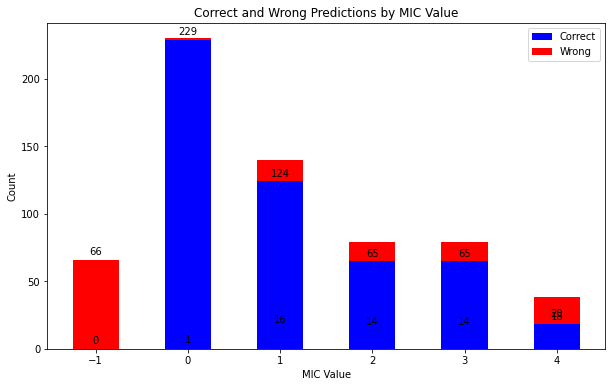

In [531]:

# Extracting values for plotting
_wrong_count = value_counts_list(_wrong)
_correct_count = value_counts_list(_correct)
mic_values = sorted(set(_wrong_count.keys()).union(set(_correct_count.keys())))
wrong_counts = [_wrong_count.get(mic, 0) for mic in mic_values]
correct_counts = [_correct_count.get(mic, 0) for mic in mic_values]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create a stacked bar chart
bar_width = 0.5
bar1 = ax.bar(mic_values, correct_counts, bar_width, label='Correct', color='b')
bar2 = ax.bar(mic_values, wrong_counts, bar_width, bottom=correct_counts, label='Wrong', color='r')

# Adding labels
ax.set_xlabel('MIC Value')
ax.set_ylabel('Count')
ax.set_title('Correct and Wrong Predictions by MIC Value')
ax.legend()

# Adding counts on top of bars
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

In [571]:
for k, v in same_x_values.items():
    print(v)
    print(k)
    break

30
(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
import numpy as np
import pandas as pd


# Iterate over val_data and val_target
same_x_values = {}
count = 0
for x, y in zip(val_data, val_target):
    if y == -1:
        x_tuple = tuple(x)
        if x_tuple not in same_x_values:
            same_x_values[x_tuple] = 1
        else:
            same_x_values[x_tuple] += 1
        # print(x)
        count += 1

print(f"Total number of x values where y == -1: {count}")
print(f"Number of unique x values where y == -1: {len(same_x_values)}")
for k, v in same_x_values.items():
    print(v)

In [596]:
regressor.predict([_t])

array([0.345608], dtype=float32)

In [597]:
_t = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_c = []
_p = []
for data, target in zip(val_data, val_target):
    if np.array_equal(data, _t):
        _c.append(target)
        _p.append(regressor.predict([data]))

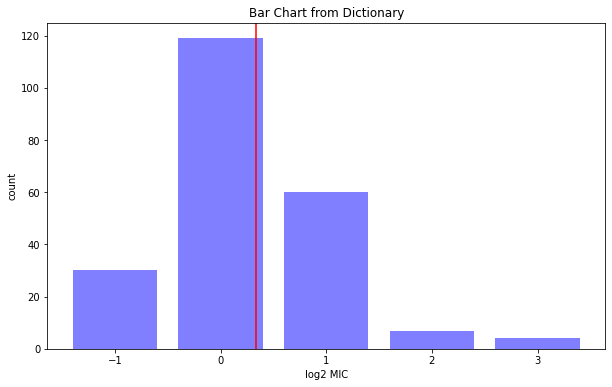

In [601]:


# Extracting keys and values from the dictionary
x_values = list(value_counts_list(_c).keys())
y_values = list(value_counts_list(_c).values())

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='blue', alpha =0.5)

# Adding labels and title
plt.ylabel('count')
plt.xlabel('log2 MIC')
plt.title('Bar Chart from Dictionary')
plt.axvline(x = 0.34, color = 'r', label = 'axvline - full height')

# Show the plot
plt.show()

In [ ]:

# Initialize dictionaries to store errors and counts for each true MIC value across different sample sizes
errors_per_true_value = {i: {50: 0, 100: 0, 500: 0, 1000: 0, 2000: 0, 3000: 0, 4000: 0, 5000: 0} for i in range(-1, 5)}
counts_per_true_value = {i: {50: 0, 100: 0, 500: 0, 1000: 0, 2000: 0, 3000: 0, 4000: 0, 5000: 0} for i in range(-1, 5)}

for x in [50, 100, 500, 1000, 2000, 3000, 4000, 5000]:
    print('====sample used', x)
    X_train, X_rest, y_train, y_rest = train_test_split(
        train_data,
        train_target,
        train_size=x,
        stratify=train_target,
        random_state=42
    )
    print(y_train.value_counts())
    value_counts_ = y_train.value_counts()
    for value, count in value_counts_.items():
        counts_per_true_value[value][x] = count

    # Initialize the XGBoost Regressor
    regressor = xgb.XGBRegressor(max_depth=6, random_state=0, n_estimators=100)

    # Fit the model
    regressor.fit(X_train, y_train)

    # Predict on the test data
    test_predictions = regressor.predict(val_data)

    # Calculate regression metrics
    mae = mean_absolute_error(val_target, test_predictions)
    mse = mean_squared_error(val_target, test_predictions)
    r2 = r2_score(val_target, test_predictions)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R²):", r2)

    # Calculate and store errors and counts for each true MIC value
    for pred, true in zip(test_predictions, val_target):
        if not is_within_doubling_dilution(pred, true):
            errors_per_true_value[true][x] += 1
    
    
# Plotting the errors for each true MIC value across different sample sizes
plt.figure(figsize=(12, 8))

for true_value, error_counts in errors_per_true_value.items():
    sample_sizes = list(error_counts.keys())
    counts = list(error_counts.values())
    plt.plot(sample_sizes, counts, label=f'True MIC value {true_value}')

plt.xlabel('Sample Size')
plt.ylabel('Count of Errors')
plt.title('Error Counts for Each True MIC Value Across Different Sample Sizes')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the counts for each true MIC value across different sample sizes
plt.figure(figsize=(12, 8))

for true_value, counts in counts_per_true_value.items():
    sample_sizes = list(counts.keys())
    count_values = list(counts.values())
    plt.plot(sample_sizes, count_values, label=f'True MIC value {true_value}')

plt.xlabel('Sample Size')
plt.ylabel('Count')
plt.title('Counts of Each True MIC Value Across Different Sample Sizes')
plt.legend()
plt.grid(True)
plt.show()

In [435]:
_ = []
for pred, true in zip(test_predictions, val_target):
    # print('=========================')
    # print(is_within_doubling_dilution(pred, true))
    # print(pred, true)
    if is_within_doubling_dilution(pred, true) == False:
        _.append(true)
value_counts_list(_)

{-1.0: 81, 4.0: 22, 2.0: 21, 3.0: 20, 1.0: 8, 0.0: 3}

In [494]:
# balanced data with resampling
X_train, X_rest, y_train, y_rest = train_test_split(
        train_data,
        train_target,
        train_size=1500,
        stratify=train_target,
        random_state=42
    )
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [497]:
# balanced data without resampling
def balanced_sampling(X, y):
    # Reset indices to ensure alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Find the counts of each class
    value_counts = y.value_counts()
    min_count = value_counts.min()
    
    # Lists to hold the balanced data
    X_balanced_list = []
    y_balanced_list = []

    # Sample an equal number of samples from each class based on min_count
    for value in value_counts.index:
        X_class = X[y == value]
        y_class = y[y == value]
        # Randomly sample without replacement
        X_sampled = X_class.sample(min_count, random_state=42)
        y_sampled = y_class.sample(min_count, random_state=42)
        X_balanced_list.append(X_sampled)
        y_balanced_list.append(y_sampled)

    # Concatenate the lists to get the balanced dataset
    X_balanced = pd.concat(X_balanced_list).to_numpy()
    y_balanced = pd.concat(y_balanced_list)
    
    return X_balanced, y_balanced



# Manually balance the classes
X_train_balanced, y_train_balanced = balanced_sampling(pd.DataFrame(train_data), train_target)

# Print value counts before and after balancing to verify
print("Value counts before balancing:")
print(y_train.value_counts())

print("Value counts after balancing:")
print(y_train_balanced.value_counts())

Value counts before balancing:
0.00     547
1.00     332
3.00     187
2.00     187
-1.00    157
4.00      90
Name: EMB_MIC, dtype: int64
Value counts after balancing:
0.00     340
1.00     340
2.00     340
3.00     340
-1.00    340
4.00     340
Name: EMB_MIC, dtype: int64


In [ ]:
def select_features(X_train, Y_train, X_test, percentage_remaining):
    import warnings
    warnings.filterwarnings("ignore")
    full_features = X_train.shape[1]
    goal_features = int(full_features*percentage_remaining)
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=goal_features)
    # learn relationship from training data
    fs.fit(X_train, Y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
    #get the scores for each feature with 

In [498]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# train_data, val_data, train_target, val_target  = data_split(train_data, train_target)

# Assuming train_data, train_target, test_data, and val_target are already defined

# Initialize the RandomForestRegressor
# regressor = xgb.XGBRegressor(max_depth=100, random_state=0, n_estimators=1000)
regressor = xgb.XGBRegressor(objective="reg:squarederror", 
                             reg_lambda=0, 
                             min_child_weight= 4, 
                             learning_rate=0.05,
                             n_estimators=100,
                             max_depth=6,
                             colsample_bytree=0.5,
                             subsample=0.7,
                             n_jobs=4)

# regressor.fit(train_data, train_target)
# regressor.fit(train_data, train_target)
# regressor.fit(X_train, y_train)
regressor.fit(X_train_balanced, y_train_balanced)
print(y_train_balanced.value_counts())
# Predict on the test data
test_predictions = regressor.predict(val_data)

# Calculate regression metrics
mae = mean_absolute_error(val_target, test_predictions)
mse = mean_squared_error(val_target, test_predictions)
r2 = r2_score(val_target, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target):
    _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5]
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(test_predictions, val_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate residuals
# residuals = val_target - test_predictions

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(val_target, test_predictions, edgecolors=(0, 0, 0))
# plt.plot([val_target.min(), val_target.max()], [val_target.min(), val_target.max()], 'k--', lw=4)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(test_predictions, residuals, edgecolors=(0, 0, 0))
# plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='r', linestyles='dashed')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Predicted')
# plt.show()

0.00     340
1.00     340
2.00     340
3.00     340
-1.00    340
4.00     340
Name: EMB_MIC, dtype: int64
Mean Absolute Error (MAE): 0.6784587233692785
Mean Squared Error (MSE): 0.7068552936536091
R-squared (R²): 0.6370414004220506
Doubling Dilution Accuracy: 0.7895569620253164


In [ ]:
y

In [485]:
type(X_train)

numpy.ndarray

In [482]:
print(y_train_balanced.value_counts())

0.00     547
1.00     547
3.00     547
4.00     547
-1.00    547
2.00     547
Name: EMB_MIC, dtype: int64


#### MLSE

In [24]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming data_split function and data are defined
train_data, val_data, train_target, val_target = data_split(train_data, train_target)

# Define the custom loss function (MLSE)
def mean_log_squared_error(preds, dtrain):
    labels = dtrain
    errors = np.log(preds + 1) - np.log(labels + 1)
    grad = 2 * errors / (preds + 1)
    hess = 2 / (preds + 1)
    return grad, hess

# Initialize the XGBoost regressor with the custom objective function
regressor = xgb.XGBRFRegressor(max_depth=100, random_state=0, n_estimators=1000, objective=mean_log_squared_error)
regressor.fit(train_data, train_target)

# Predict on the validation data
val_predictions = regressor.predict(val_data)

# Calculate regression metrics
mae = mean_absolute_error(val_target, val_predictions)
mse = mean_squared_error(val_target, val_predictions)
r2 = r2_score(val_target, val_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target):
    _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5]
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(val_predictions, val_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate residuals
# residuals = val_target - val_predictions

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(val_target, val_predictions, edgecolors=(0, 0, 0))
# plt.plot([val_target.min(), val_target.max()], [val_target.min(), val_target.max()], 'k--', lw=4)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(val_predictions, residuals, edgecolors=(0, 0, 0))
# plt.hlines(y=0, xmin=val_predictions.min(), xmax=val_predictions.max(), colors='r', linestyles='dashed')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Predicted')
# plt.show()


/tmp/ipykernel_101153/3119671021.py:13: RuntimeWarning: divide by zero encountered in log
  errors = np.log(preds + 1) - np.log(labels + 1)
/tmp/ipykernel_101153/3119671021.py:13: RuntimeWarning: invalid value encountered in log
  errors = np.log(preds + 1) - np.log(labels + 1)
/tmp/ipykernel_101153/3119671021.py:15: RuntimeWarning: divide by zero encountered in true_divide
  hess = 2 / (preds + 1)


Mean Absolute Error (MAE): 1.1603887393666898
Mean Squared Error (MSE): 2.2447091992688417
R-squared (R²): -0.2263319818728582
Doubling Dilution Accuracy: 0.6009852216748769


#### gridCV

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train_data, val_data, train_target, val_target  = data_split(train_data, train_target)

# XGBoost regressor
regressor = xgb.XGBRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the grid search
grid_search.fit(train_data, train_target)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Use the best estimator to make predictions
best_regressor = grid_search.best_estimator_
y_pred = best_regressor.predict(val_data)

# Evaluate the model
mse = mean_squared_error(val_target, y_pred)
print(f"Mean Squared Error: {mse}")

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(y_pred, val_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

### LDS

In [253]:
train_data, test_data, train_target, test_target  = data_split(aa_array, np.log2(mic_aa['EMB_MIC']))
train_data, val_data, train_target, val_target  = data_split(train_data, train_target)

In [207]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Assuming train_data, train_target, test_data, and val_target are already defined

# Initialize the RandomForestRegressor
regressor = xgb.XGBRegressor(max_depth=100, random_state=0, n_estimators=1000)
regressor.fit(train_data, train_target)

# Predict on the test data
test_predictions = regressor.predict(val_data)

# Calculate regression metrics
mae = mean_absolute_error(val_target, test_predictions)
mse = mean_squared_error(val_target, test_predictions)
r2 = r2_score(val_target, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target):
    _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5]
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(test_predictions, val_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate residuals
# residuals = val_target - test_predictions

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(val_target, test_predictions, edgecolors=(0, 0, 0))
# plt.plot([val_target.min(), val_target.max()], [val_target.min(), val_target.max()], 'k--', lw=4)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(test_predictions, residuals, edgecolors=(0, 0, 0))
# plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='r', linestyles='dashed')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Predicted')
# plt.show()

Mean Absolute Error (MAE): 0.6990140139259433
Mean Squared Error (MSE): 0.8983323126495205
R-squared (R²): 0.5097347945887549
Doubling Dilution Accuracy: 0.7883495145631068


In [208]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

from scipy.ndimage import convolve1d

labels = np.unique(val_target).tolist()
input_labels = val_target
# preds, labels: [Ns,], "Ns" is the number of total samples
preds, labels = 1, labels
# assign each label to its corresponding bin (start from 0)
# with your defined get_bin_idx(), return bin_index_per_label: [Ns,] 
# bin_index_per_label = [get_bin_idx(label) for label in labels]
bin_index_per_label = [labels.index(label) for label in input_labels]


# calculate empirical (original) label distribution: [Nb,]
# "Nb" is the number of bins
Nb = max(bin_index_per_label) + 1
num_samples_of_bins = dict(Counter(bin_index_per_label))
emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

# lds_kernel_window: [ks,], here for example, we use gaussian, ks=5, sigma=2
lds_kernel_window = get_lds_kernel_window(kernel='gaussian', ks=5, sigma=2)
# calculate effective label distribution: [Nb,]
eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')


import torch
def weighted_mse_loss(inputs, targets, weights=None):
    loss = (inputs - targets) ** 2
    loss = loss.tolist()
    if weights is not None:
        weights = torch.tensor(weights, dtype=torch.float32)
        loss = torch.tensor(loss, dtype=torch.float32)
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

# Use re-weighting based on effective label distribution, sample-wise weights: [Ns,]
eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
weights = [np.float32(1 / x) for x in eff_num_per_label]

# calculate loss
# loss = weighted_mse_loss(preds, labels, weights=weights)
loss = weighted_mse_loss(test_predictions, val_target, weights=weights)

[0.5141771801835668, 1.3422502773592202, 0.08005420054260615, 3.9355936677566774, 0.04594847140856473, 0.014383554960261336, 0.49525657419114655, 1.6802778554335172, 0.22421603558177594, 0.5141771801835668, 0.08005420054260615, 0.025994910403426275, 0.49525657419114655, 2.9483001598245275, 0.21525262431629244, 1.6459312209016455, 1.58768581854443, 0.08776721481233185, 1.6459312209016455, 0.06761770950893808, 1.58768581854443, 0.08005420054260615, 0.08776721481233185, 0.08776721481233185, 0.08005420054260615, 0.283547901310385, 0.08776721481233185, 5.211808241260685, 0.5141771801835668, 0.0034968589221193724, 0.7605694224048989, 0.6492482589237625, 1.6459312209016455, 0.5141771801835668, 2.35943959788807, 0.08005420054260615, 0.08005420054260615, 3.2607671187870437, 0.5141771801835668, 0.00235857372723558, 0.08005420054260615, 0.5141771801835668, 0.025139768678876573, 3.3299551323139553, 0.08005420054260615, 2.9483001598245275, 1.5780332377844388, 0.5141771801835668, 0.08005420054260615

In [196]:
import torch
def weighted_mse_loss(inputs, targets, weights=None):
    loss = (inputs - targets) ** 2
    loss = loss.tolist()
    print(loss)
    print(weights)
    if weights is not None:
        weights = torch.tensor(weights, dtype=torch.float32)
        loss = torch.tensor(loss, dtype=torch.float32)
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

# Use re-weighting based on effective label distribution, sample-wise weights: [Ns,]
eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
weights = [np.float32(1 / x) for x in eff_num_per_label]

# calculate loss
# loss = weighted_mse_loss(preds, labels, weights=weights)
loss = weighted_mse_loss(test_predictions, val_target, weights=weights)

[0.09534949614338561, 0.007844370161876668, 0.5091964339847124, 0.0002821454220480746, 0.6518169735637116, 5.227716360055879, 0.08203640934176804, 1.6583215689536246e-06, 0.6518169735637116, 0.1915024341747653, 0.5091964339847124, 0.27746873182224263, 0.08203640934176804, 0.5478597494994233, 0.5091964339847124, 1.0940172534183148, 0.22743825415182073, 0.27362851599264104, 0.5091964339847124, 0.15363686637124374, 0.25099343208915403, 1.3608411866483474, 0.4777752216034381, 6.253405080966331, 2.330974748553505, 5.227716360055879, 0.6518169735637116, 0.160783044957725, 1.6112817547750324e-07, 0.5091964339847124, 12.344345329222278, 0.09534949614338561, 0.11124326076448199, 0.09534949614338561, 0.5091964339847124, 0.5091964339847124, 1.7129237706833331, 0.6518169735637116, 0.09534949614338561, 0.002111659546244482, 0.08203640934176804, 0.5091964339847124, 0.22743825415182073, 0.03711331832079168, 0.27362851599264104, 0.09534949614338561, 0.9974507863188506, 0.08203640934176804, 0.082036409

In [218]:
import numpy as np
from collections import Counter
from scipy.ndimage import gaussian_filter1d, convolve1d
from scipy.signal.windows import triang

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

def transform_targets(train_target, kernel='gaussian', ks=5, sigma=2):
    # Calculate empirical label distribution
    labels = np.unique(train_target).tolist()
    bin_index_per_label = [labels.index(label) for label in train_target]

    Nb = max(bin_index_per_label) + 1
    num_samples_of_bins = dict(Counter(bin_index_per_label))
    emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

    # Apply LDS kernel to get effective label distribution
    lds_kernel_window = get_lds_kernel_window(kernel=kernel, ks=ks, sigma=sigma)
    eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

    # Calculate effective number of samples per label
    eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]

    # Return the transformed target values
    return eff_num_per_label

# Example usage
train_target = np.array(train_target)  # Example training targets
transformed_targets = transform_targets(train_target, kernel='gaussian', ks=5, sigma=2)

print("Original Targets:", train_target)
print("Transformed Targets:", transformed_targets)


Original Targets: [ 3.  0.  0. ...  0. -1.  0.]
Transformed Targets: [4642, 7395, 7395, 7395, 7395, 2456, 8263, 8263, 7395, 7395, 7395, 7563, 2456, 8263, 7395, 6063, 8263, 7395, 4642, 7395, 7395, 7395, 8263, 7395, 8263, 8263, 8263, 8263, 6063, 4642, 7395, 7395, 7563, 8263, 7395, 8263, 7395, 8263, 7395, 8263, 8263, 4642, 4642, 4642, 7395, 8263, 8263, 7395, 7395, 8263, 7395, 8263, 7563, 6063, 2456, 7395, 7563, 7395, 8263, 4642, 8263, 7395, 2456, 4642, 8263, 7395, 7563, 6063, 7395, 7395, 7395, 8263, 4642, 7395, 7395, 3701, 7395, 4642, 8263, 4642, 8263, 7395, 7395, 7395, 8263, 4642, 6063, 6063, 8263, 8263, 6063, 8263, 8263, 6063, 8263, 7395, 7395, 8263, 7563, 7395, 7563, 6063, 7395, 4642, 7563, 4642, 7395, 7395, 7395, 7395, 8263, 8263, 8263, 8263, 7395, 7563, 6063, 7563, 7395, 4642, 8263, 7395, 8263, 7563, 7395, 6063, 8263, 8263, 7395, 7395, 7563, 8263, 7395, 7563, 7395, 8263, 7395, 6063, 8263, 7395, 7563, 8263, 7563, 6063, 7395, 8263, 4642, 6063, 7395, 7395, 4642, 8263, 7395, 7395, 4642, 

[1, 5, 11, 14, 45, 13, 6, 5]
[ 3.44343275  6.43865389 15.53757702 18.70712009 19.32286661 17.60150705
 13.99314201  4.95570057]
Original Targets: [ 0  0  1  3  0  0  3  1  0  1  0  0  0 -3 -3 -1 -2  0 -1 -2]
Transformed Targets (eff_num_per_label): [19.322866614719196, 19.322866614719196, 17.601507054945436, 4.955700569635863, 19.322866614719196, 19.322866614719196, 4.955700569635863, 17.601507054945436, 19.322866614719196, 17.601507054945436, 19.322866614719196, 19.322866614719196, 19.322866614719196, 6.438653889016275, 6.438653889016275, 18.707120093485948, 15.537577017735154, 19.322866614719196, 18.707120093485948, 15.537577017735154]


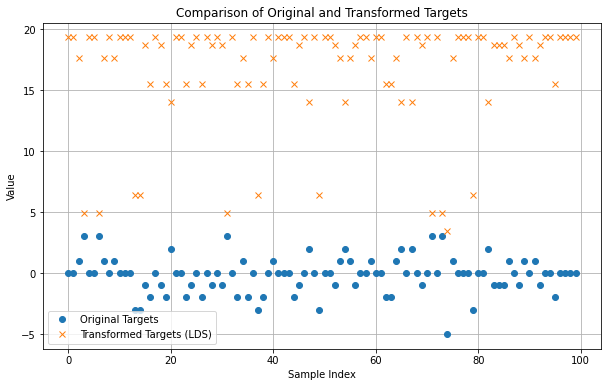

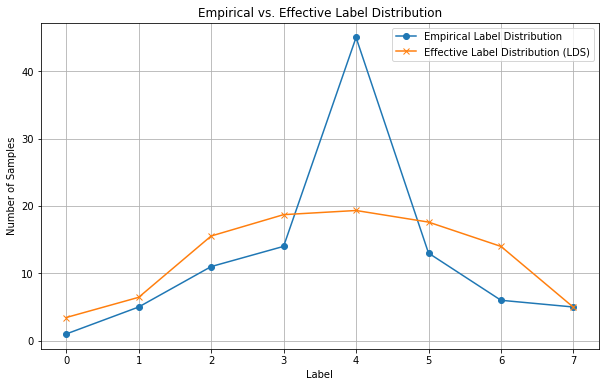

Empirical Label Distribution: [1, 5, 11, 14, 45, 13, 6, 5]
Effective Label Distribution (LDS): [ 3.44343275  6.43865389 15.53757702 18.70712009 19.32286661 17.60150705
 13.99314201  4.95570057]


In [237]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.ndimage import gaussian_filter1d, convolve1d
from scipy.signal.windows import triang

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))
    
    return kernel_window

def transform_targets(train_target, kernel='gaussian', ks=5, sigma=2):
    # Calculate empirical label distribution
    labels = np.unique(train_target).tolist()
    bin_index_per_label = [labels.index(label) for label in train_target]

    Nb = max(bin_index_per_label) + 1
    num_samples_of_bins = dict(Counter(bin_index_per_label))
    emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

    # Apply LDS kernel to get effective label distribution
    lds_kernel_window = get_lds_kernel_window(kernel=kernel, ks=ks, sigma=sigma)
    eff_label_dist = convolve1d(np.array(emp_label_dist, dtype=np.float64), weights=lds_kernel_window, mode='constant')

    # Normalize the effective label distribution to match the magnitude of the original data
    scale_factor = np.sum(emp_label_dist) / np.sum(eff_label_dist)
    eff_label_dist *= scale_factor

    # Calculate effective number of samples per label
    eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]

    # Return the transformed target values in the same format and magnitude as the original dataset
    return eff_num_per_label, emp_label_dist, eff_label_dist

# Example usage with Gaussian distribution
np.random.seed(42)
train_target = np.random.normal(loc=0, scale=2, size=100).astype(int)  # Gaussian distribution with mean=0, std=2
train_target = np.clip(train_target, -5, 5)  # Clip values to be in a reasonable range

transformed_targets, emp_label_dist, eff_label_dist = transform_targets(train_target, kernel='gaussian', ks=5, sigma=2)

print(emp_label_dist)
print(eff_label_dist)

print("Original Targets:", train_target[:20])
print("Transformed Targets (eff_num_per_label):", transformed_targets[:20])

# Plotting the original and transformed targets
plt.figure(figsize=(10, 6))
plt.plot(train_target, label='Original Targets', marker='o', linestyle='None')
plt.plot(transformed_targets, label='Transformed Targets (LDS)', marker='x', linestyle='None')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of Original and Transformed Targets')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the empirical and effective label distributions
plt.figure(figsize=(10, 6))
plt.plot(range(len(emp_label_dist)), emp_label_dist, label='Empirical Label Distribution', marker='o')
plt.plot(range(len(eff_label_dist)), eff_label_dist, label='Effective Label Distribution (LDS)', marker='x')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Empirical vs. Effective Label Distribution')
plt.legend()
plt.grid(True)
plt.show()

# Detailed printout of distributions
print("Empirical Label Distribution:", emp_label_dist)
print("Effective Label Distribution (LDS):", eff_label_dist)


In [238]:
kernel='gaussian'
ks=5
sigma=2
# Apply LDS kernel to get effective label distribution
lds_kernel_window = get_lds_kernel_window(kernel=kernel, ks=ks, sigma=sigma)
eff_label_dist = convolve1d(np.array(emp_label_dist, dtype=np.float64), weights=lds_kernel_window, mode='constant')

SyntaxError: cannot assign to literal (1140192207.py, line 1)

In [272]:
kernel='gaussian'
ks=5
sigma=2
lds_kernel_window = get_lds_kernel_window(kernel=kernel, ks=ks, sigma=sigma)
eff_label_dist = convolve1d(np.array(train_target, dtype=np.float64), weights=lds_kernel_window, mode='constant')

In [273]:
min_emp, max_emp = min(train_target), max(train_target)
min_eff, max_eff = min(eff_label_dist), max(eff_label_dist)
eff_label_dist = (eff_label_dist - min_eff) / (max_eff - min_eff) * (max_emp - min_emp) + min_emp


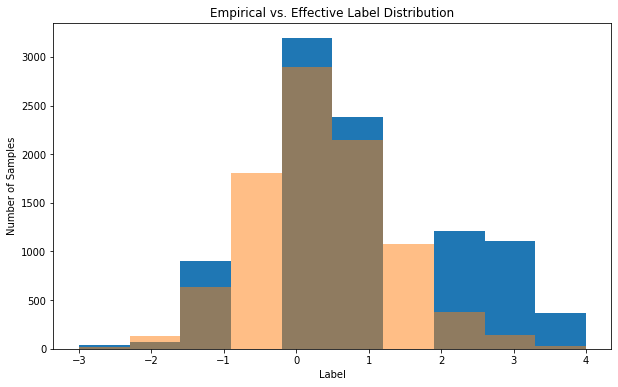

In [276]:
plt.figure(figsize=(10, 6))
plt.hist(train_target)
plt.hist(eff_label_dist, alpha=0.5)
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Empirical vs. Effective Label Distribution')
# plt.legend()
# plt.grid(True)
plt.show()

In [280]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Assuming train_data, train_target, test_data, and val_target are already defined

# Initialize the RandomForestRegressor
regressor = xgb.XGBRegressor(max_depth=200, random_state=0, n_estimators=1500)
regressor.fit(train_data, train_target)

# Predict on the test data
test_predictions = regressor.predict(val_data)

# Calculate regression metrics
mae = mean_absolute_error(val_target, test_predictions)
mse = mean_squared_error(val_target, test_predictions)
r2 = r2_score(val_target, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target):
    _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5]
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(test_predictions, val_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate residuals
# residuals = val_target - test_predictions

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(val_target, test_predictions, edgecolors=(0, 0, 0))
# plt.plot([val_target.min(), val_target.max()], [val_target.min(), val_target.max()], 'k--', lw=4)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(test_predictions, residuals, edgecolors=(0, 0, 0))
# plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='r', linestyles='dashed')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Predicted')
# plt.show()

Mean Absolute Error (MAE): 0.6980427752073614
Mean Squared Error (MSE): 0.8979396188978345
R-squared (R²): 0.5099491073548919
Doubling Dilution Accuracy: 0.7873786407766991


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Assuming train_data, train_target, test_data, and val_target are already defined

# Initialize the RandomForestRegressor
regressor = xgb.XGBRegressor(max_depth=100, random_state=0, n_estimators=1000)
regressor.fit(train_data, eff_label_dist)

# Predict on the test data
test_predictions = regressor.predict(val_data)

# Calculate regression metrics
mae = mean_absolute_error(val_target, test_predictions)
mse = mean_squared_error(val_target, test_predictions)
r2 = r2_score(val_target, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target):
    _ = [-4, -3., -2., -1.,  0.,  1.,  2.,  3.,  4, 5]
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true) for pred, true in zip(test_predictions, val_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate residuals
# residuals = val_target - test_predictions

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(val_target, test_predictions, edgecolors=(0, 0, 0))
# plt.plot([val_target.min(), val_target.max()], [val_target.min(), val_target.max()], 'k--', lw=4)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(test_predictions, residuals, edgecolors=(0, 0, 0))
# plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='r', linestyles='dashed')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Predicted')
# plt.show()

## lazyp

In [87]:
from lazypredict.Supervised import LazyRegressor


clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(train_data, test_data, train_target, test_target)
print(models)

 74%|███████▍  | 31/42 [05:55<00:35,  3.24s/it]